In [1]:
pip install multiprocess

Note: you may need to restart the kernel to use updated packages.


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from underlying import Underlying, NonTradedUnderlying
from option import Option, Vanilla, Vanilla_on_NonTraded
from trader import Trader

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sb
from tqdm import tqdm
from quantile_hedging_calculator import *
import numpy as np
import pandas as pd

from IPython import display
from time import sleep
from multiprocess import Pool

In [3]:
def trader_loop(i, option, V0, sims_t, sims_nt):
    trader = Trader(initial_capital = V0)
    return trader.simulate_hedging(option, [sims_t.iloc[[i],:], sims_nt.iloc[[i],:]], update_freq = 1, mode = 'quantile_nontraded')

In [4]:
mu_nt = 0.06
mu_t = 0.06
sigma_nt =  0.3
sigma_t =  0.3
r = 0.05
X0_nt = 100
X0_t = 100
T = 1
K = 100
repeat = 10000
values_per_year = 250

In [5]:
underlying_t = Underlying(mu_t, sigma_t, r, values_per_year)

In [6]:
rho = 0.9999999999
underlying_nt = NonTradedUnderlying(mu_t, sigma_t, underlying_t, rho)

In [7]:
call_nt = Vanilla_on_NonTraded(underlying_nt, K, T, True, 'success_ratio')
put_nt = Vanilla_on_NonTraded(underlying_nt, K, T, False, 'success_ratio')

In [8]:
call_vanilla = Vanilla(underlying_t, K, T, True)
put_vanilla = Vanilla(underlying_t, K, T, False)

In [9]:
print(call_nt.get_MC_price(X0_t, X0_nt, n_sims = 100))
print(call_vanilla.get_price(X0_t))

13.35241088402609
14.231254785985819


In [10]:
print(put_nt.get_MC_price(X0_t, X0_nt, n_sims = 100))
print(put_vanilla.get_price(X0_t))

8.06228646426973
9.354197236057232


In [11]:
rho_call = dict()
for rho in [-0.999, -0.5, 0, 0.5, 0.999]:
    underlying_nt = NonTradedUnderlying(mu_nt, sigma_nt, underlying_t, rho)
    rho_call[rho] = Vanilla_on_NonTraded(underlying_nt, K, T, True, 'success_ratio')

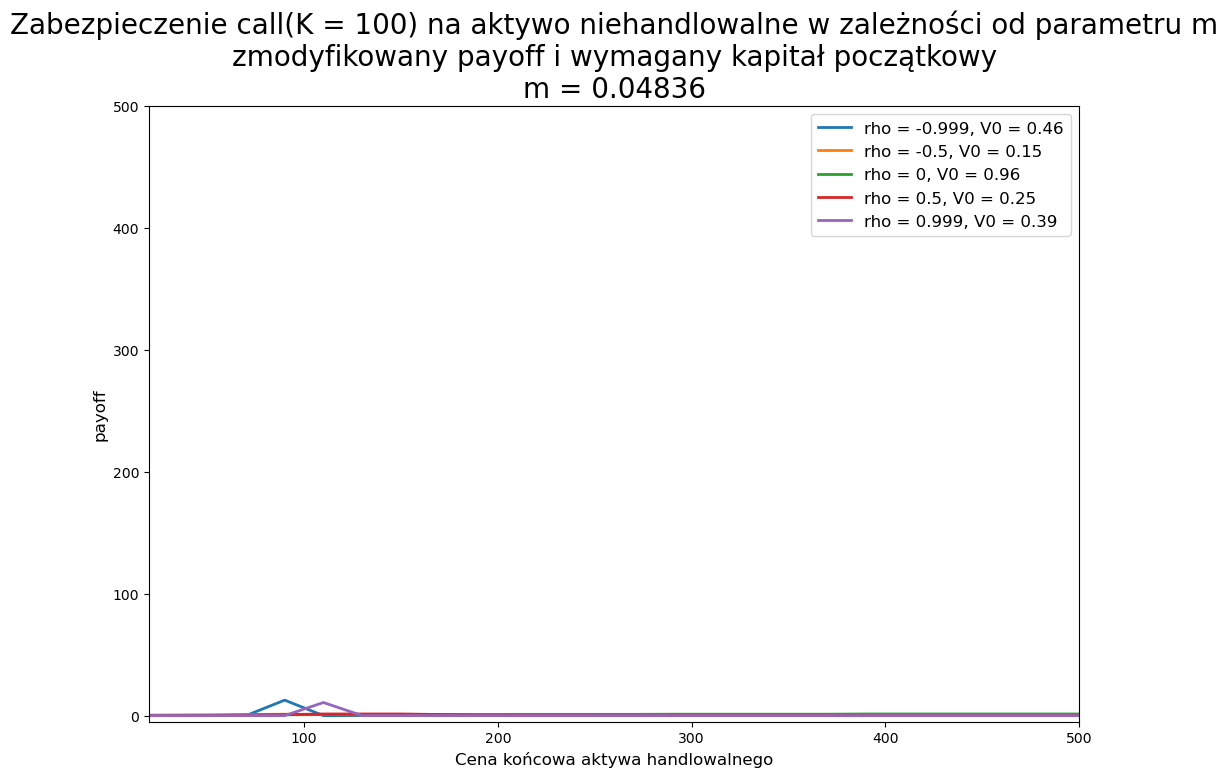

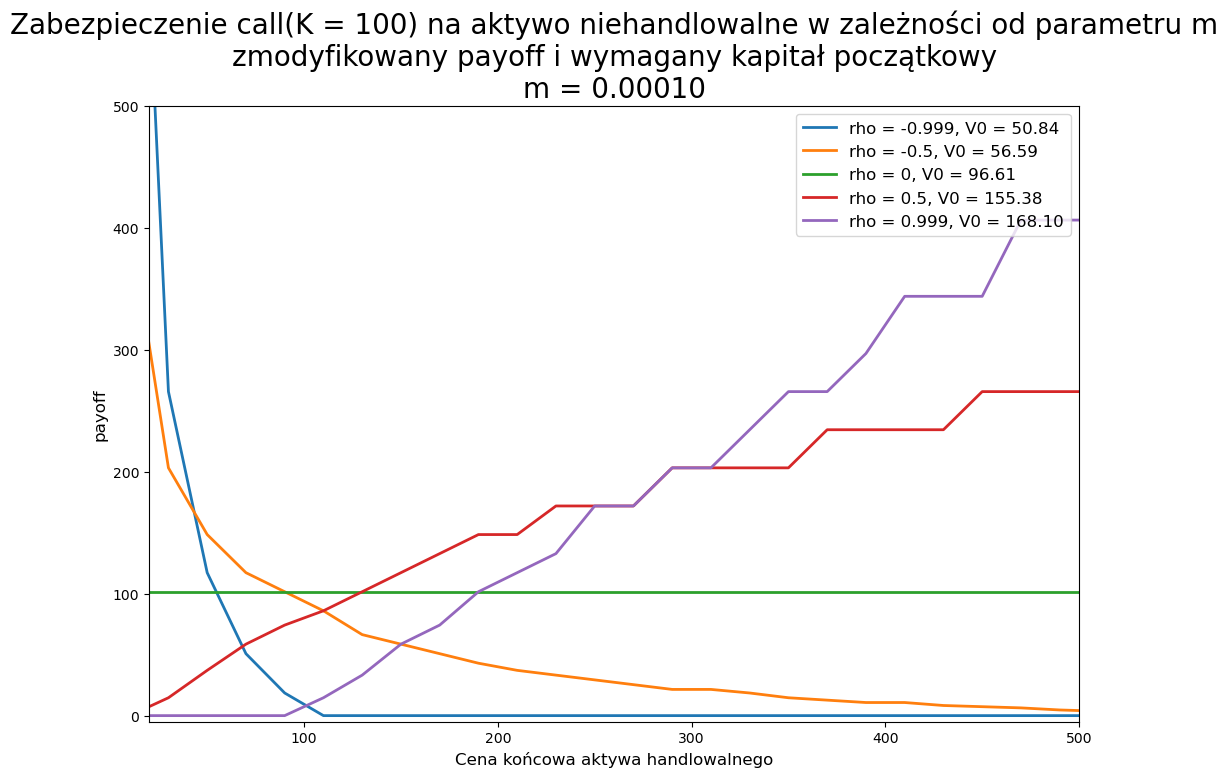

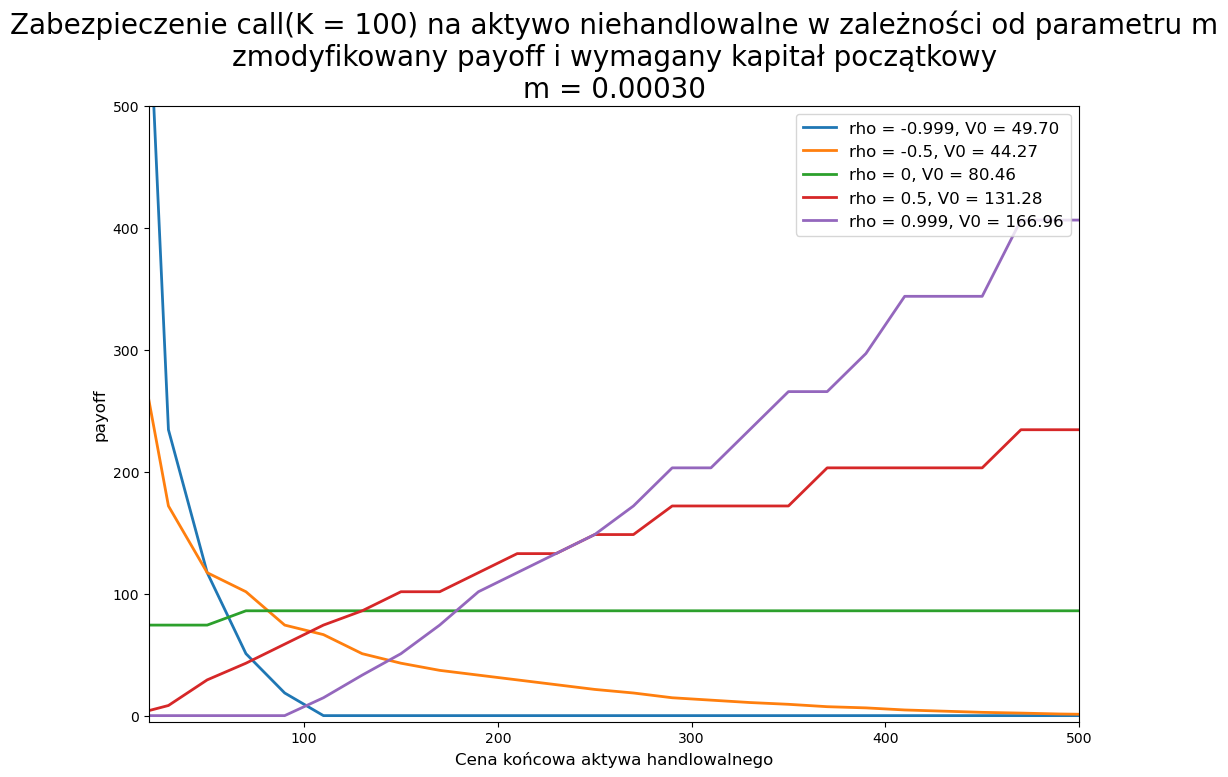

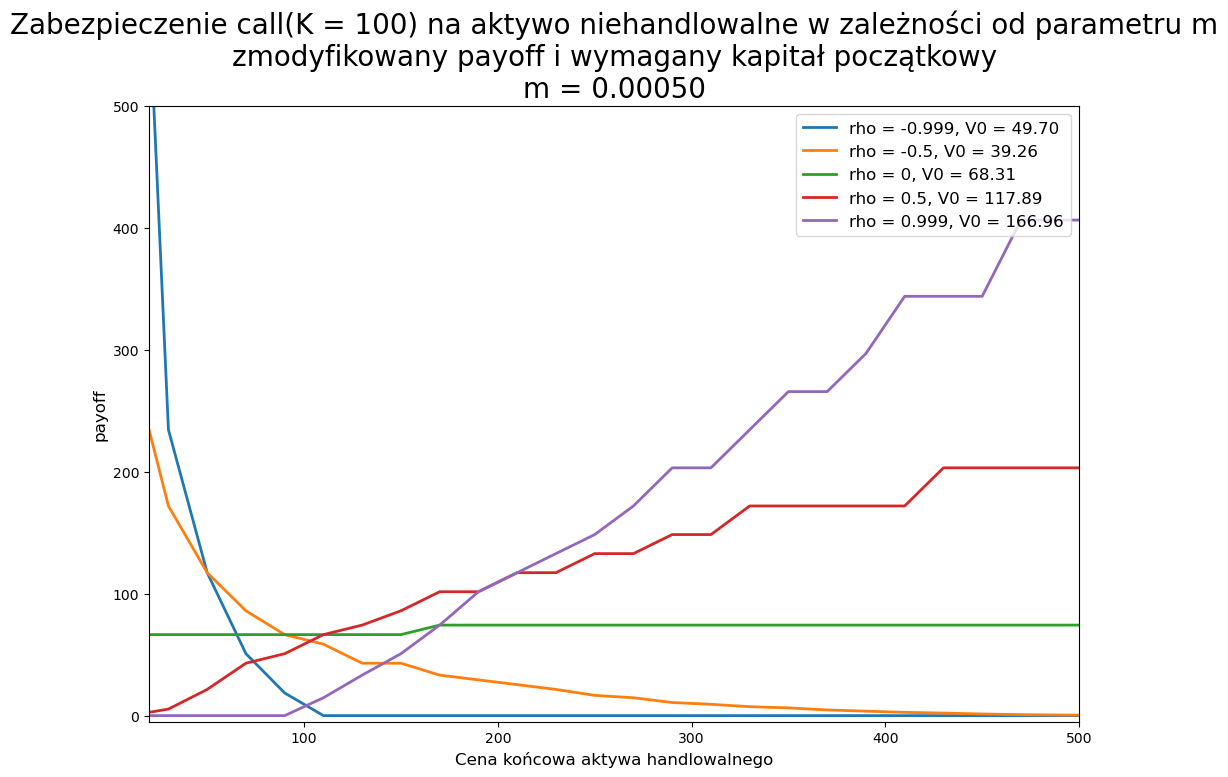

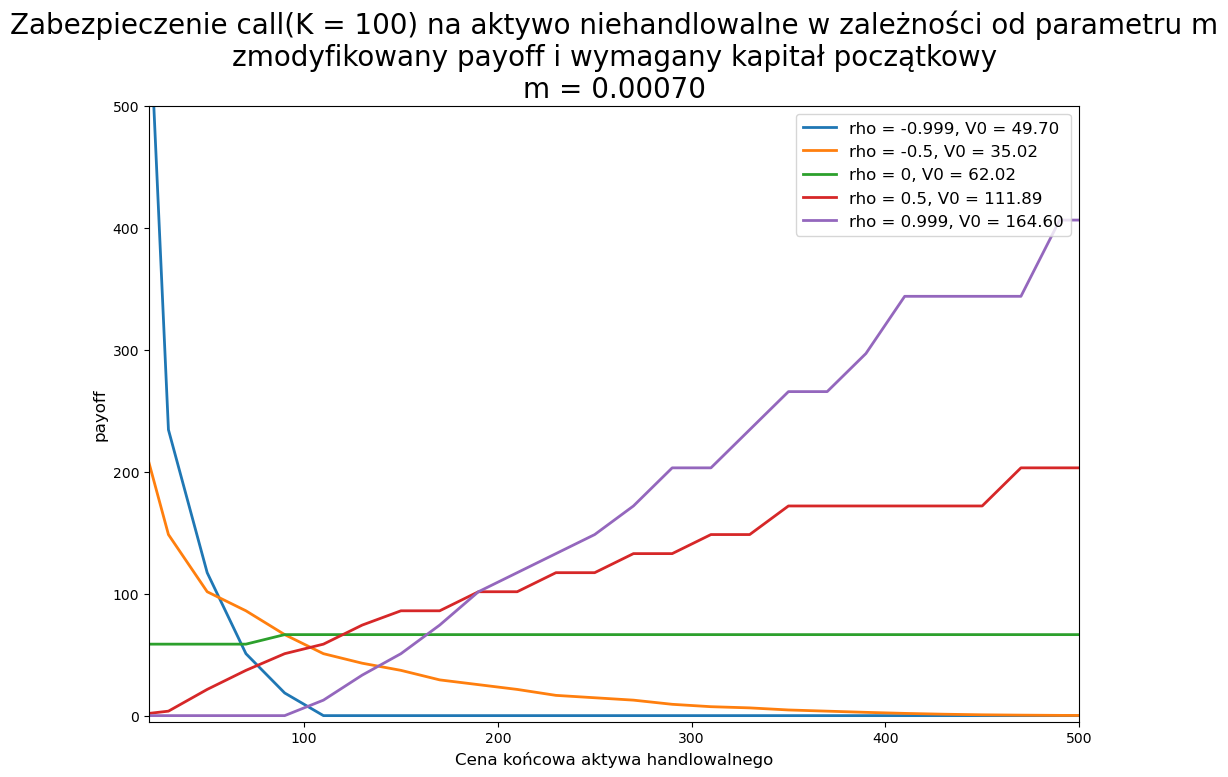

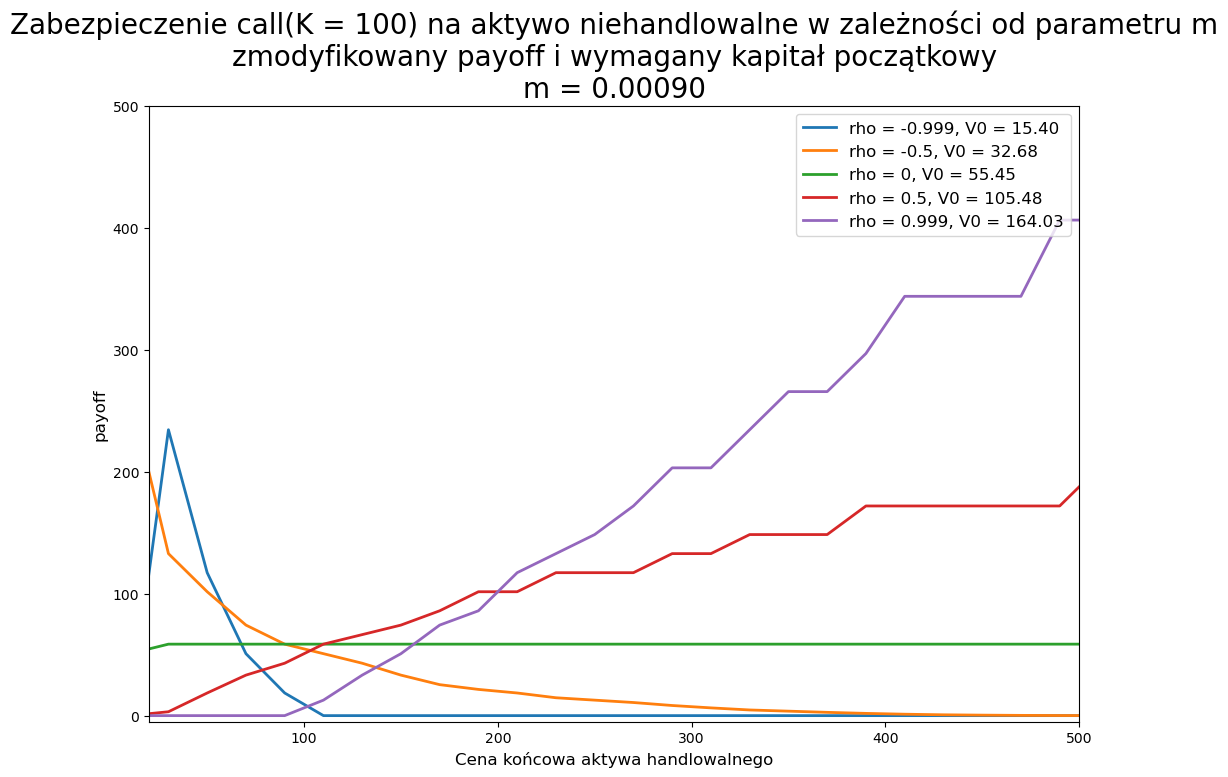

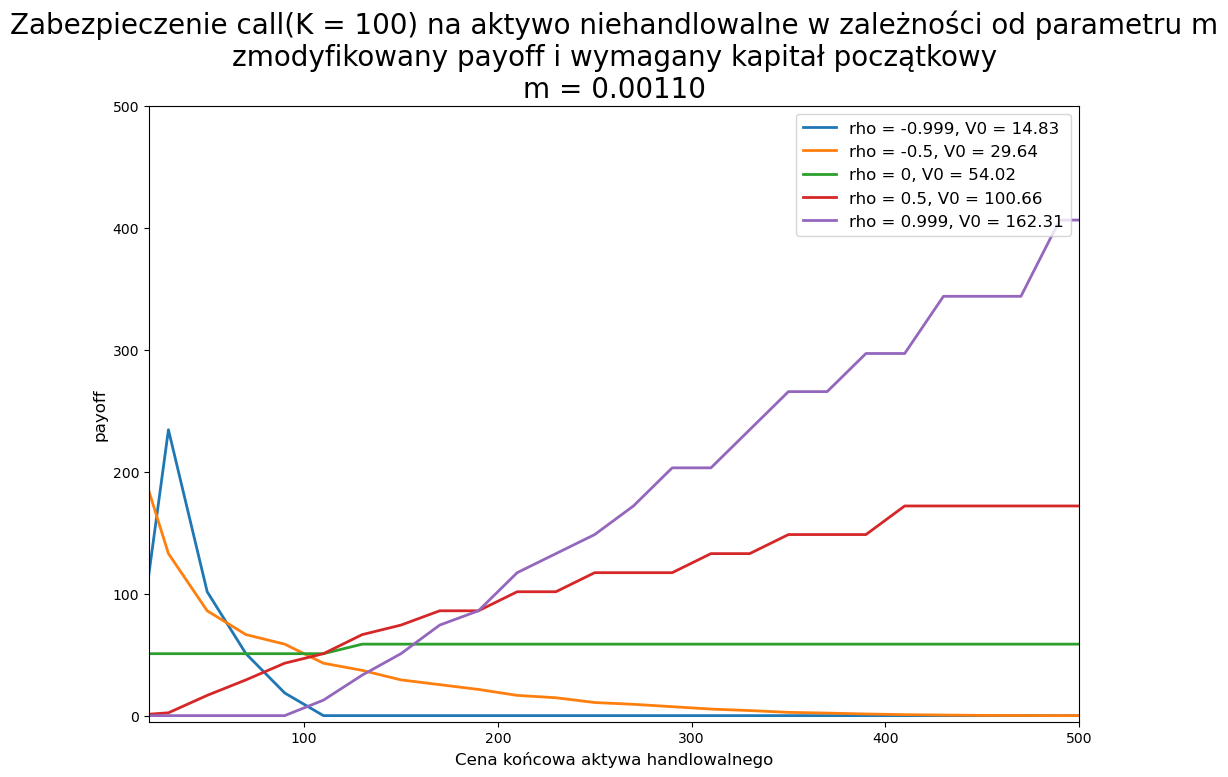

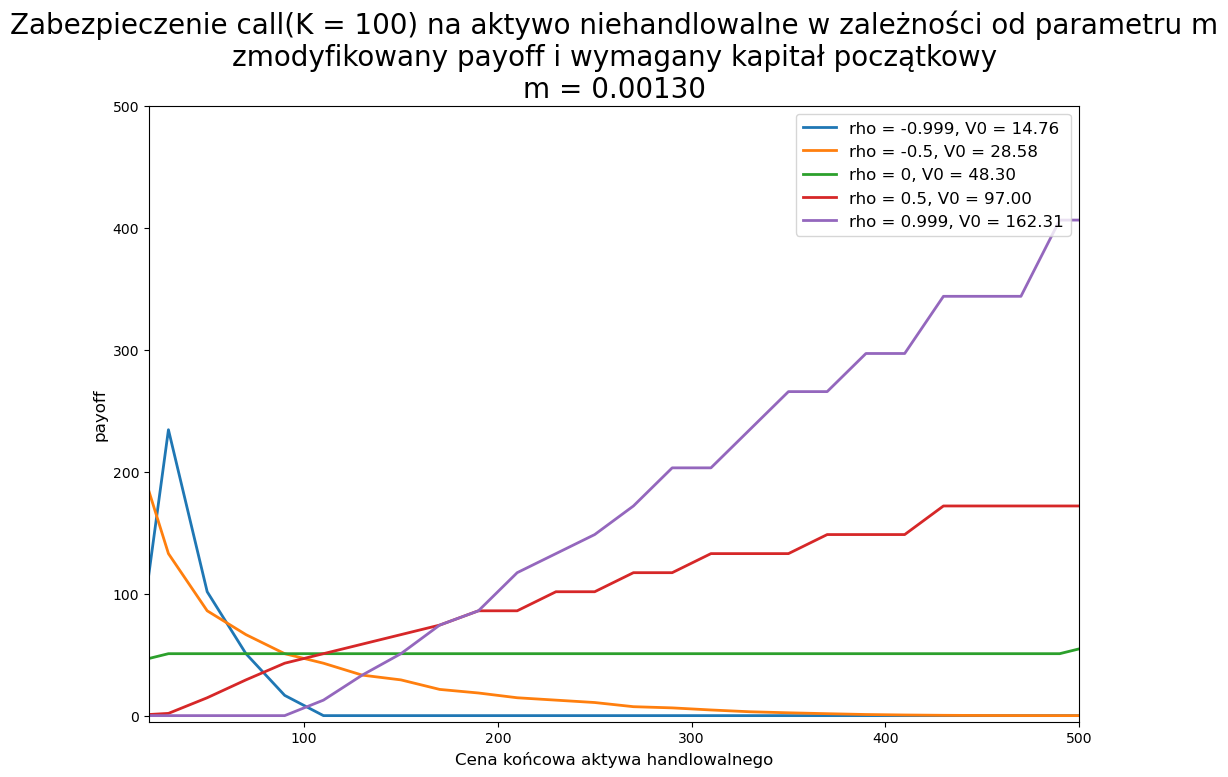

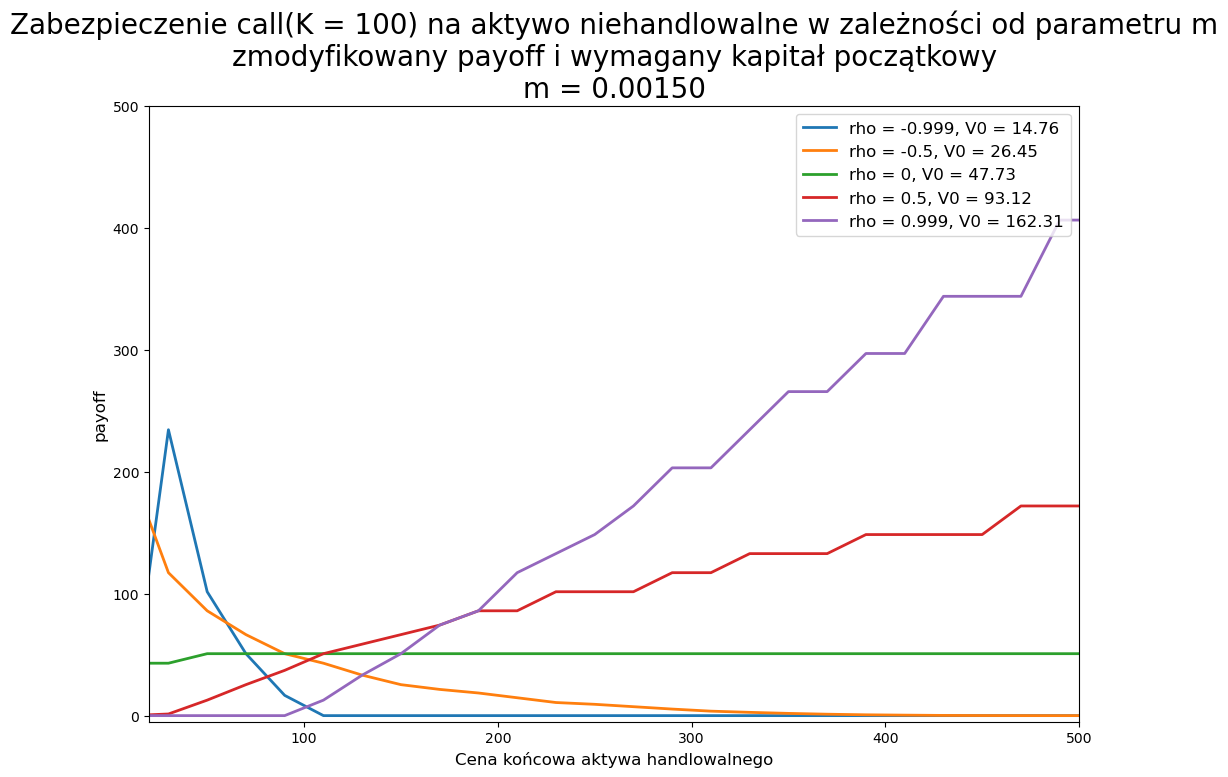

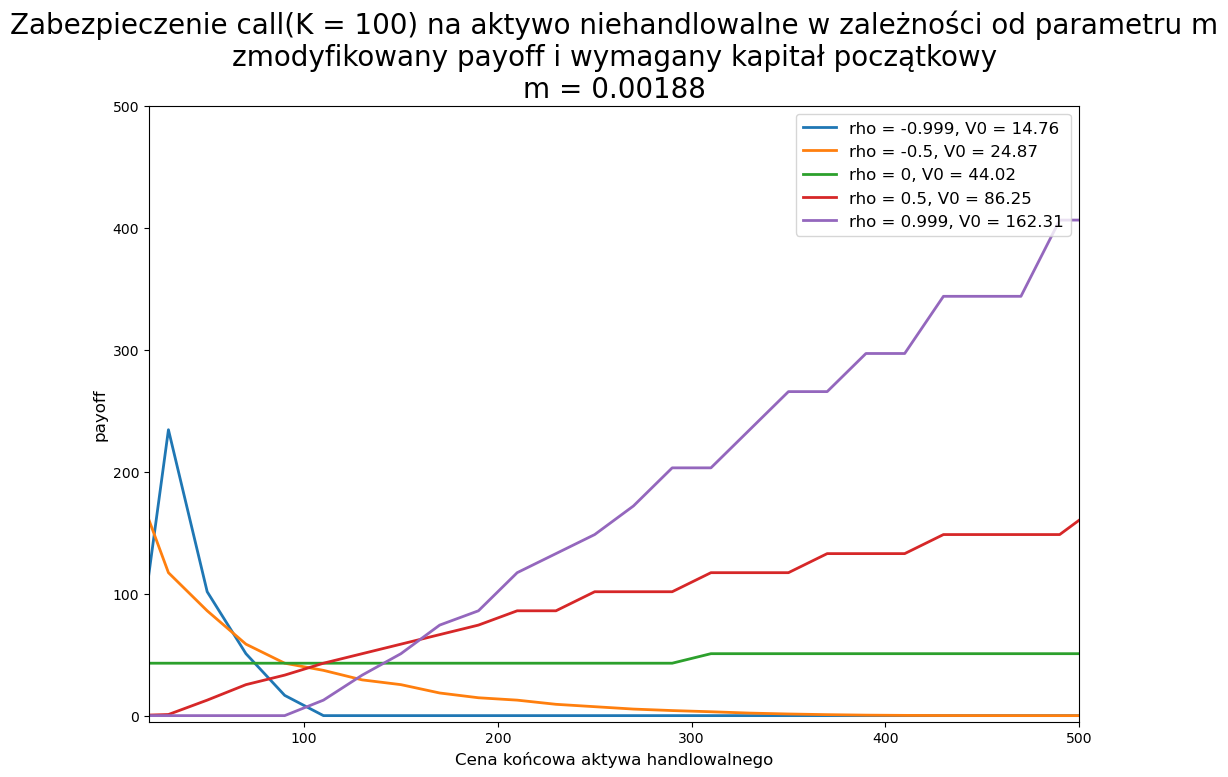

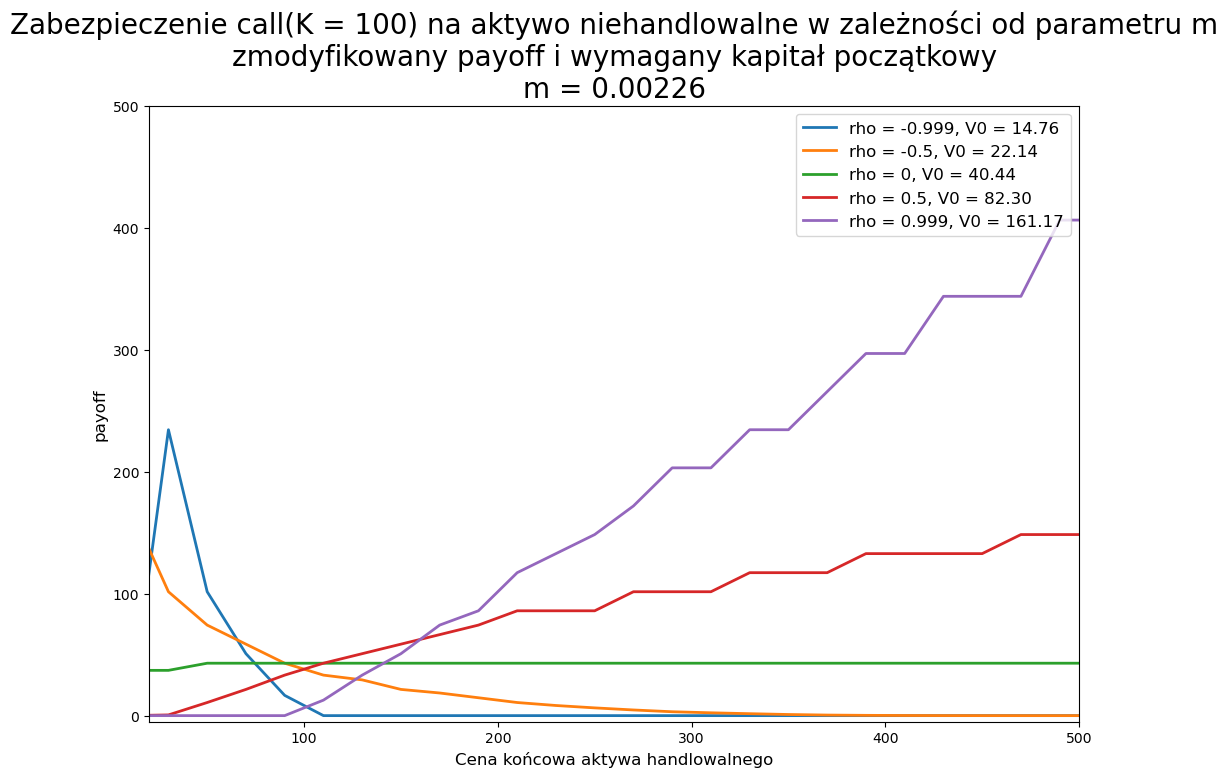

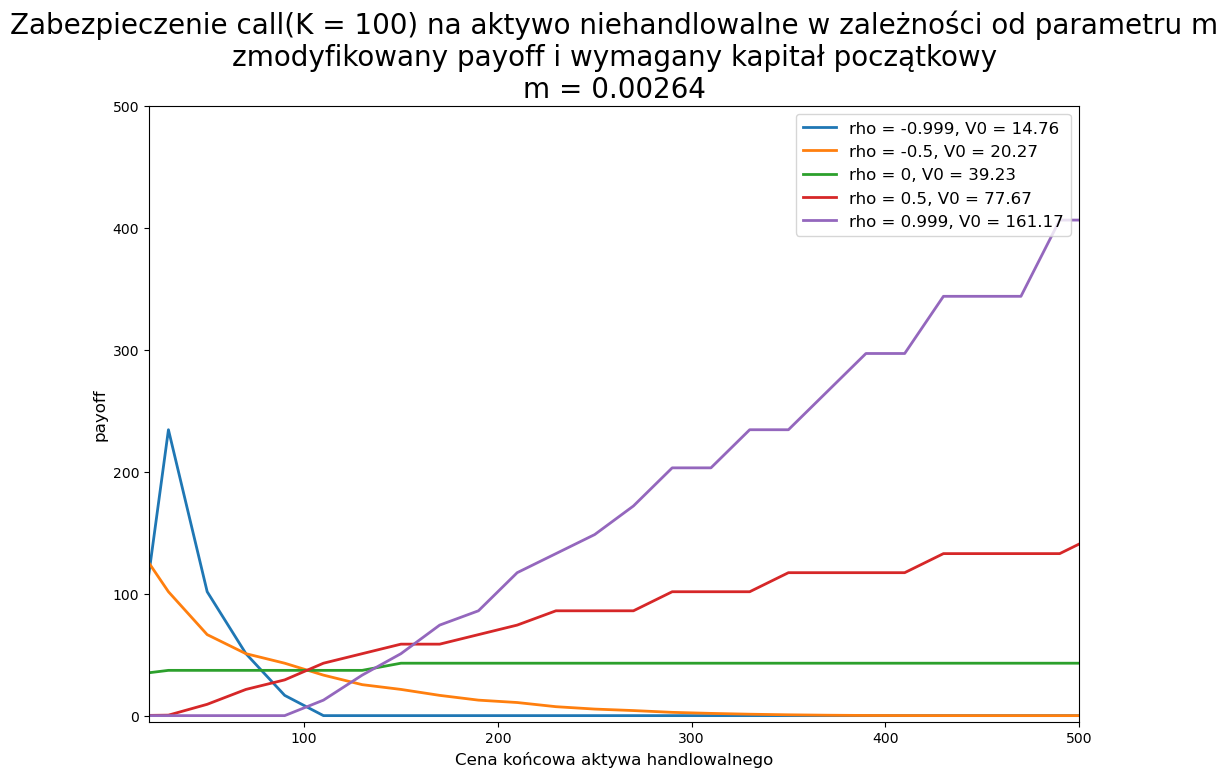

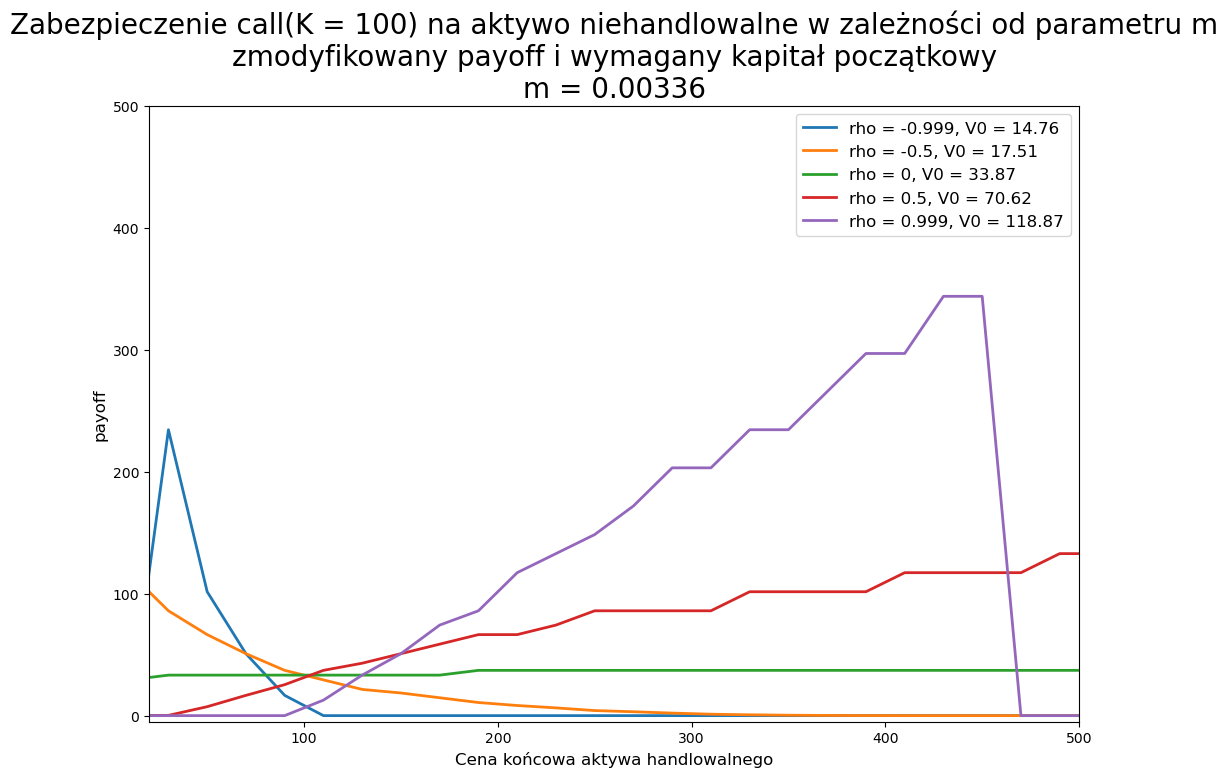

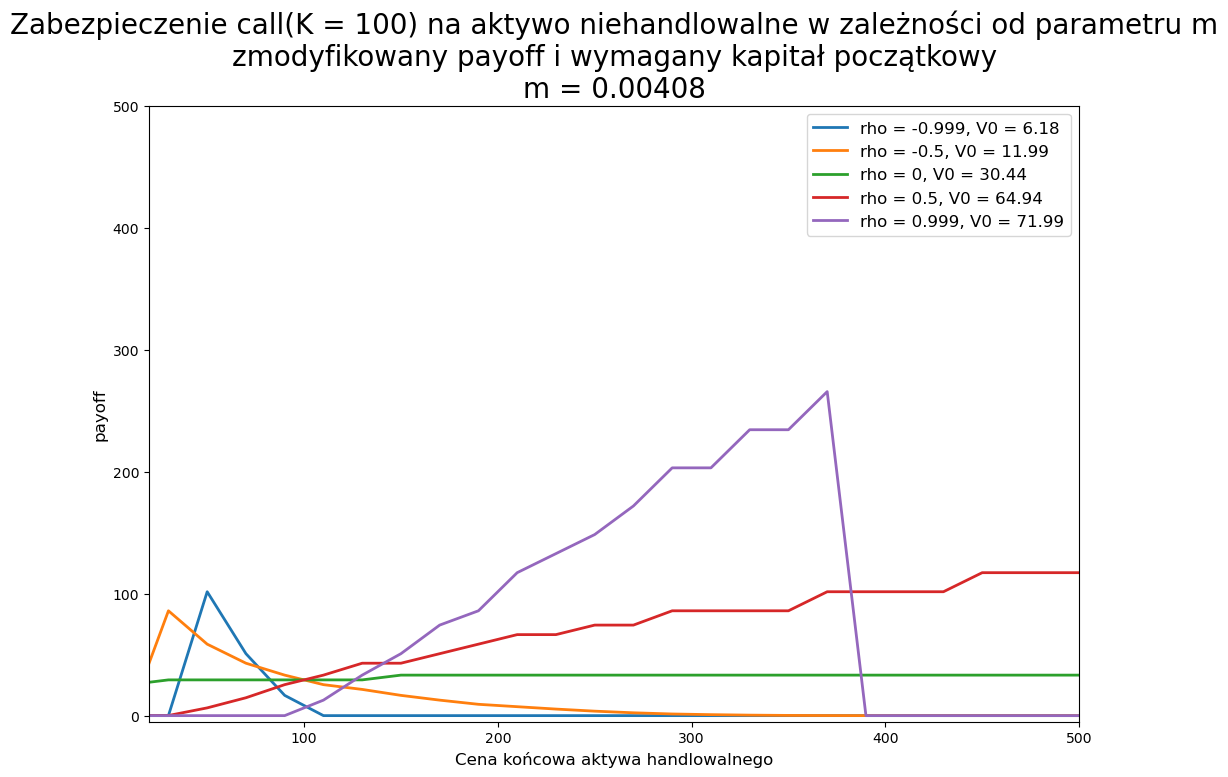

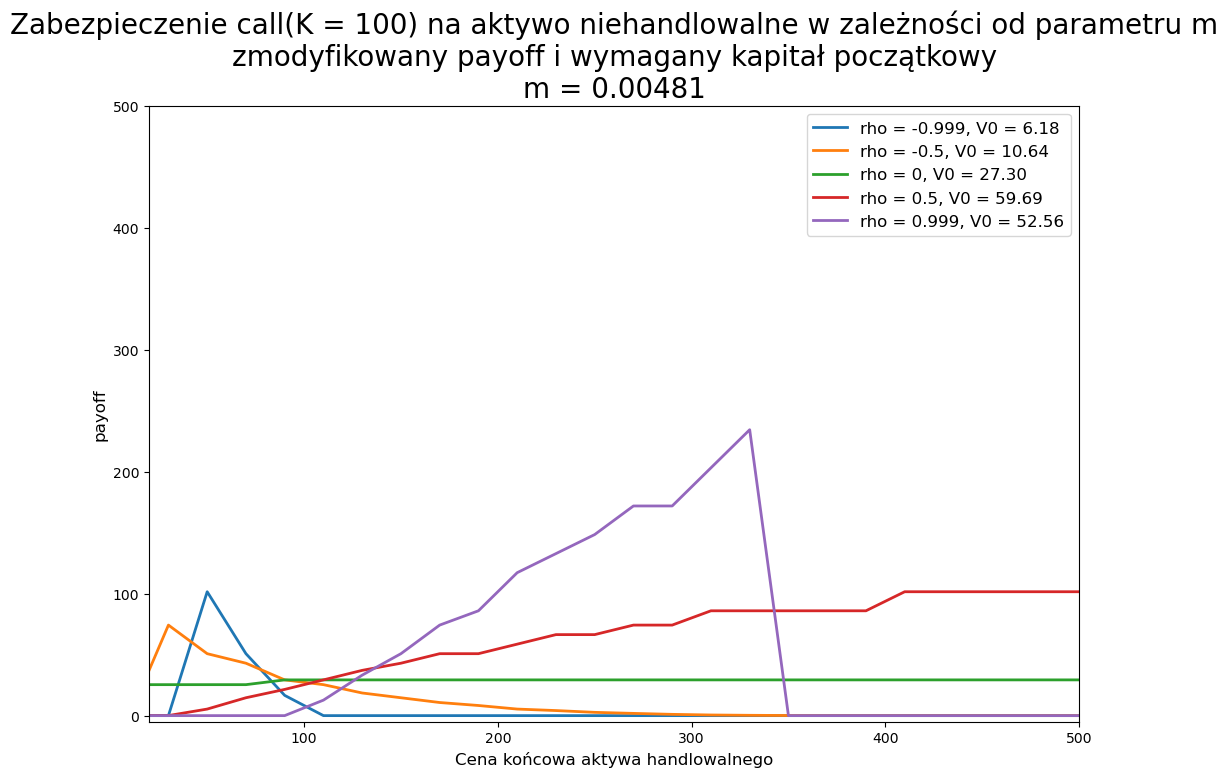

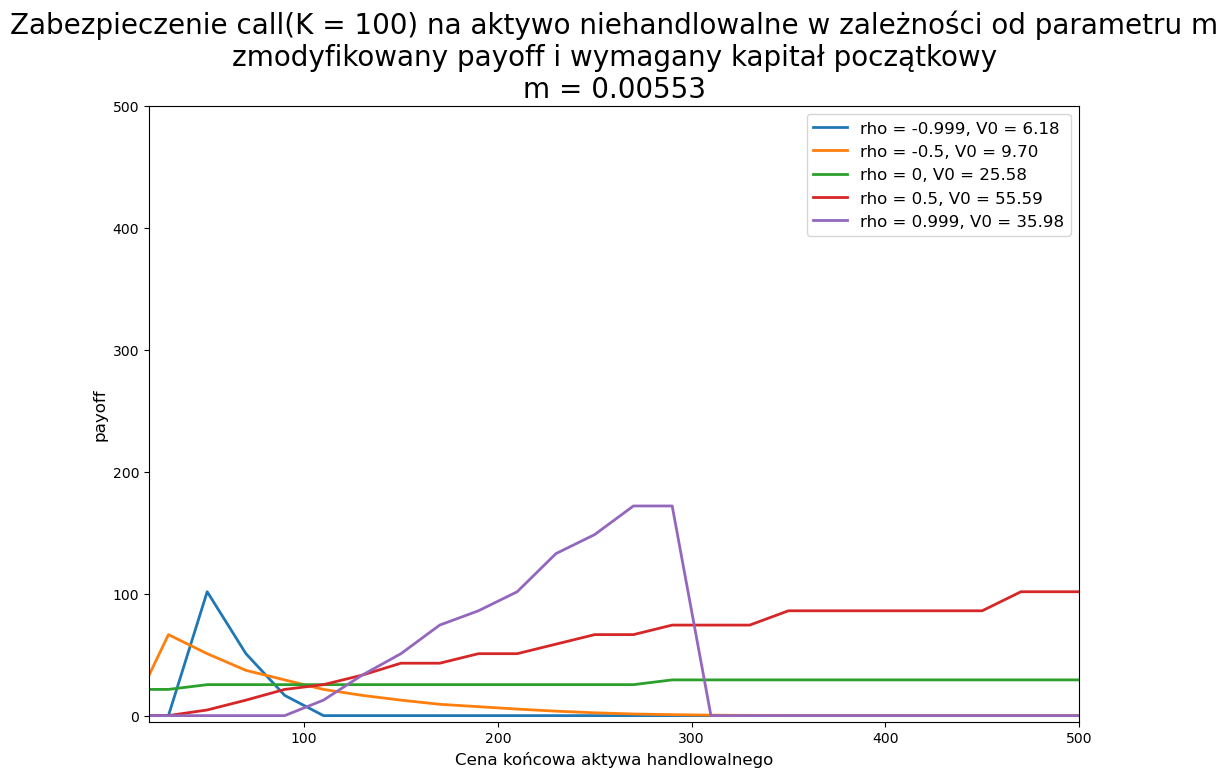

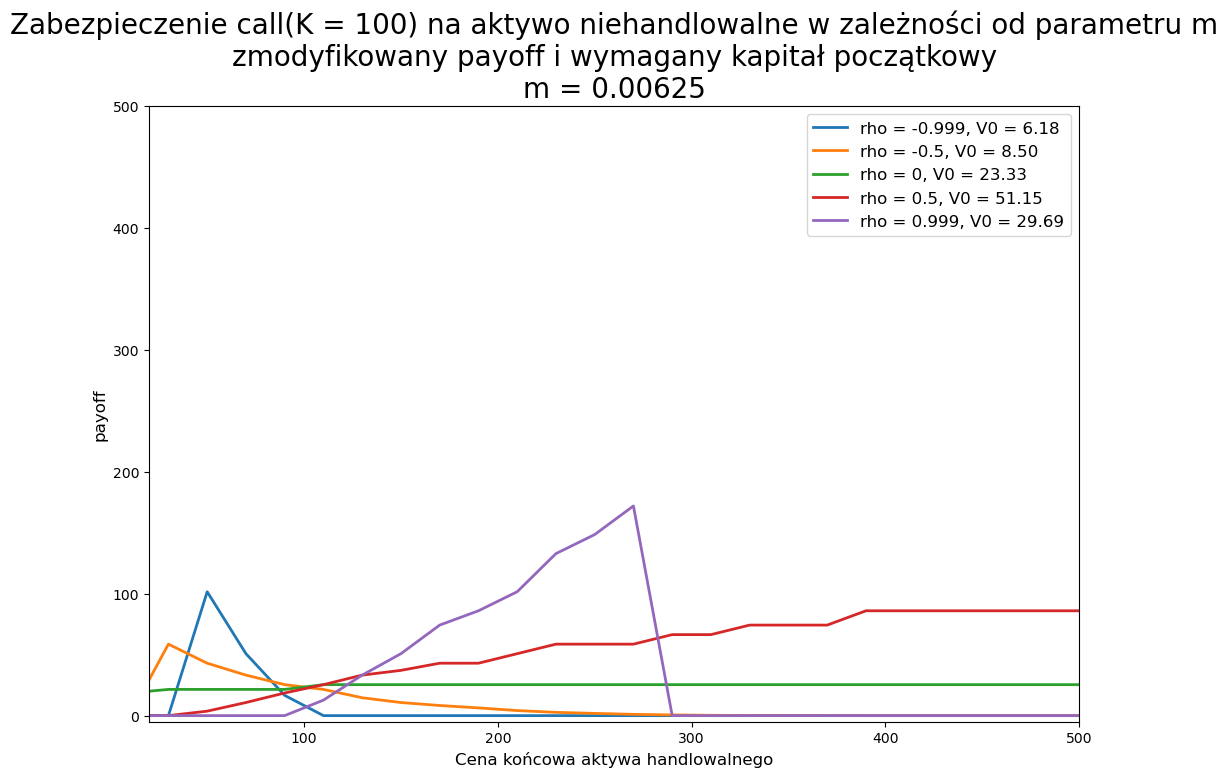

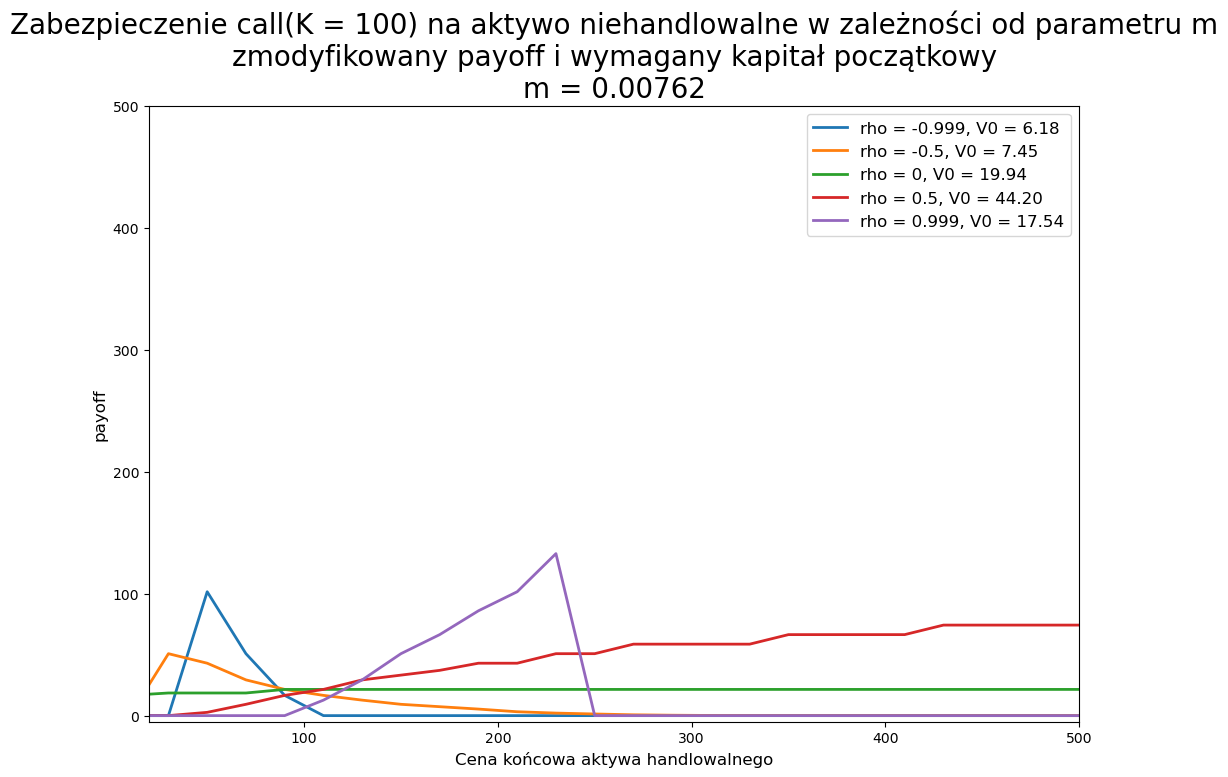

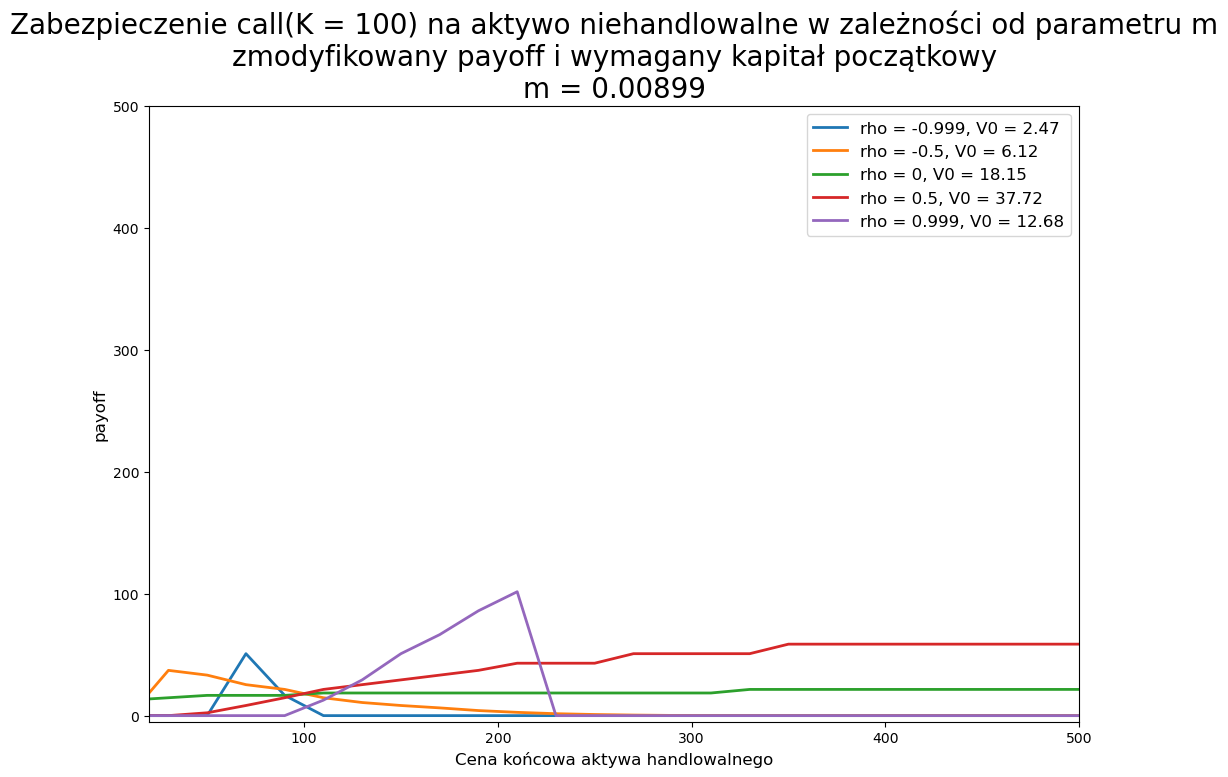

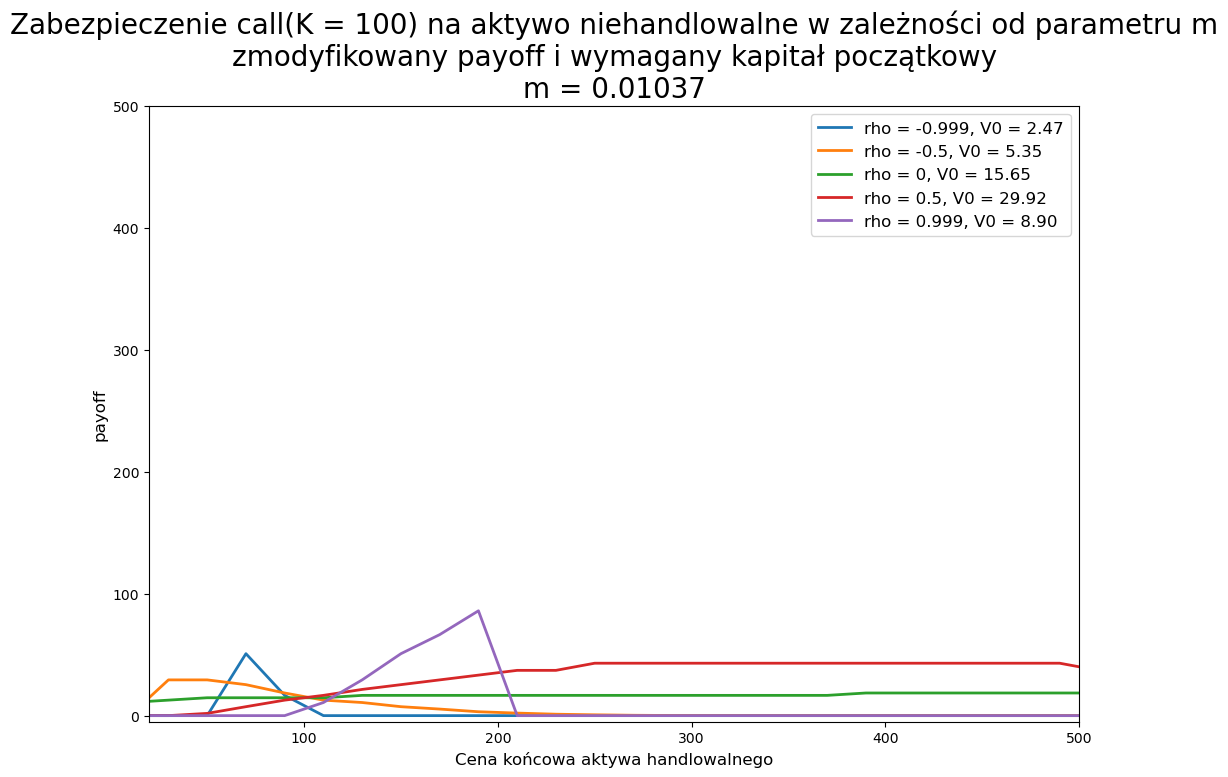

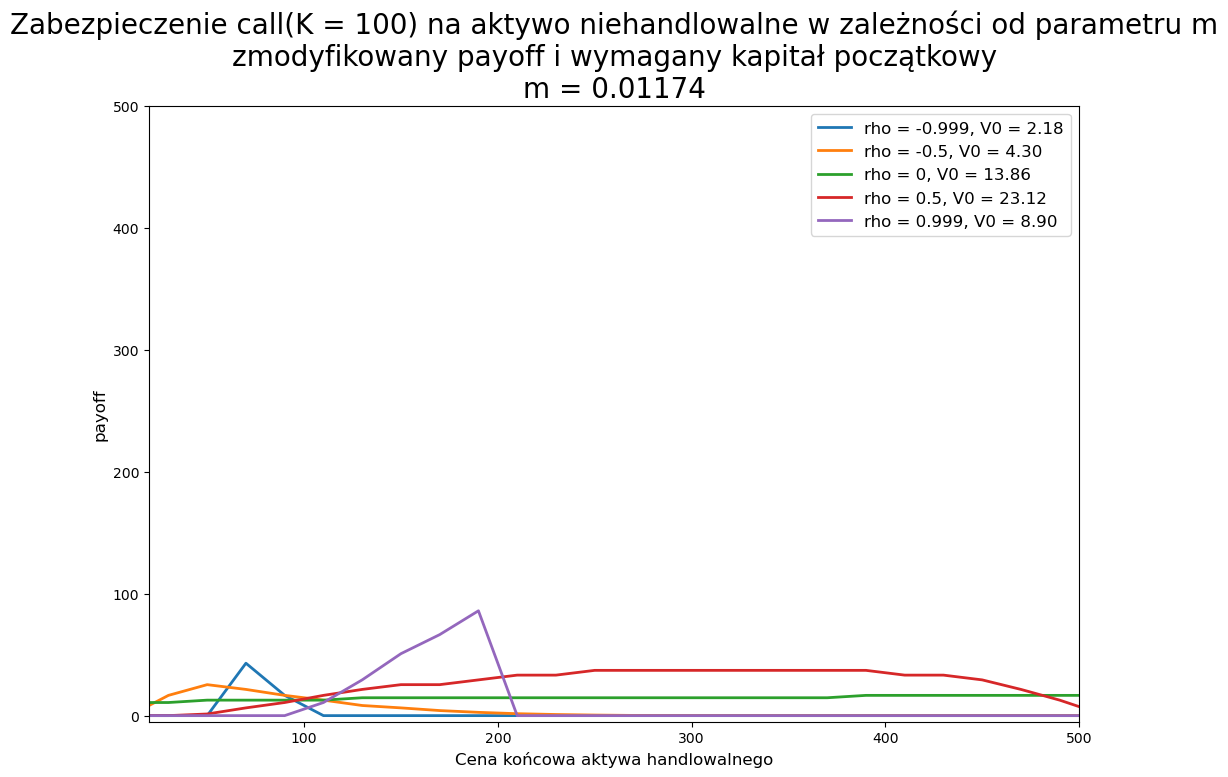

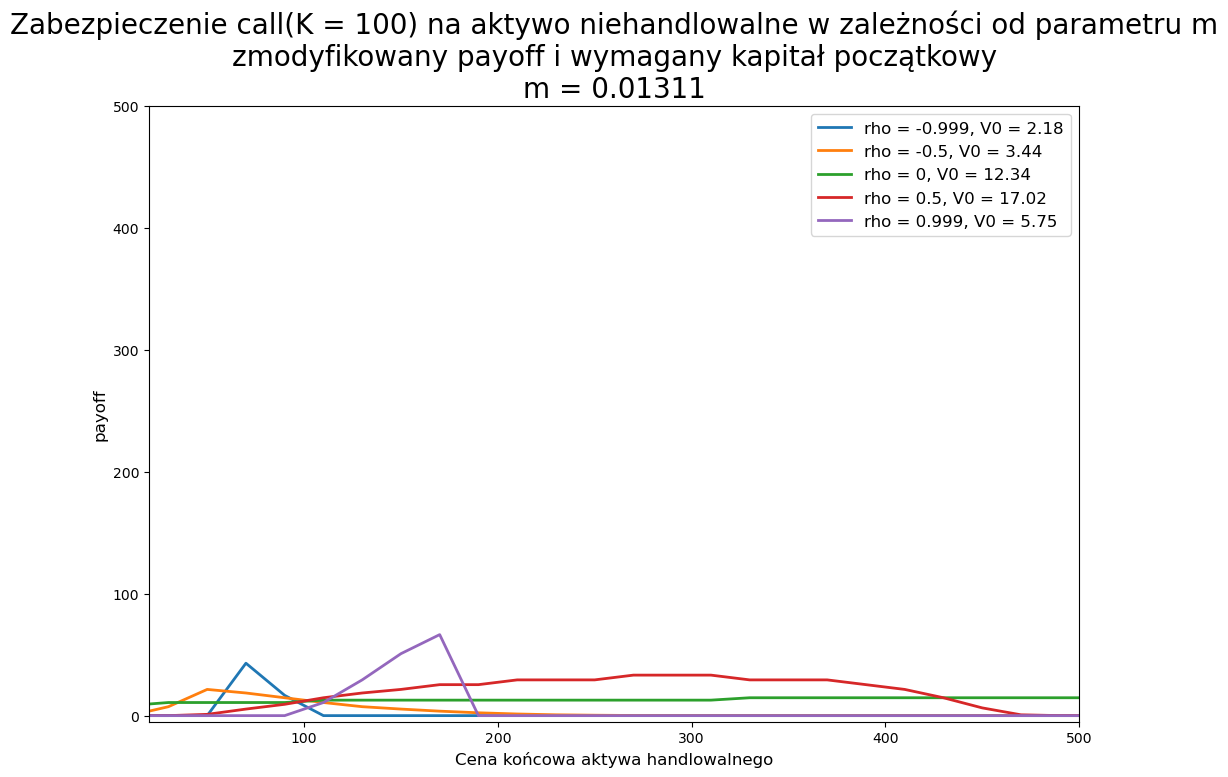

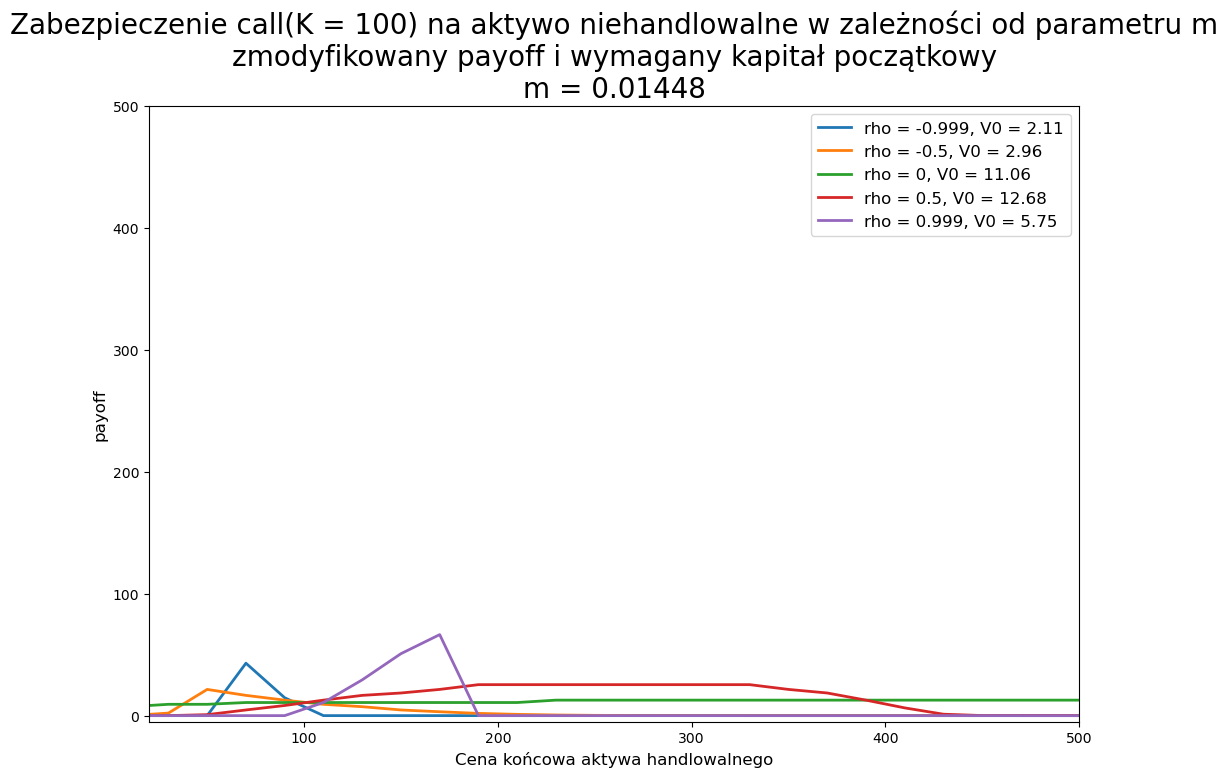

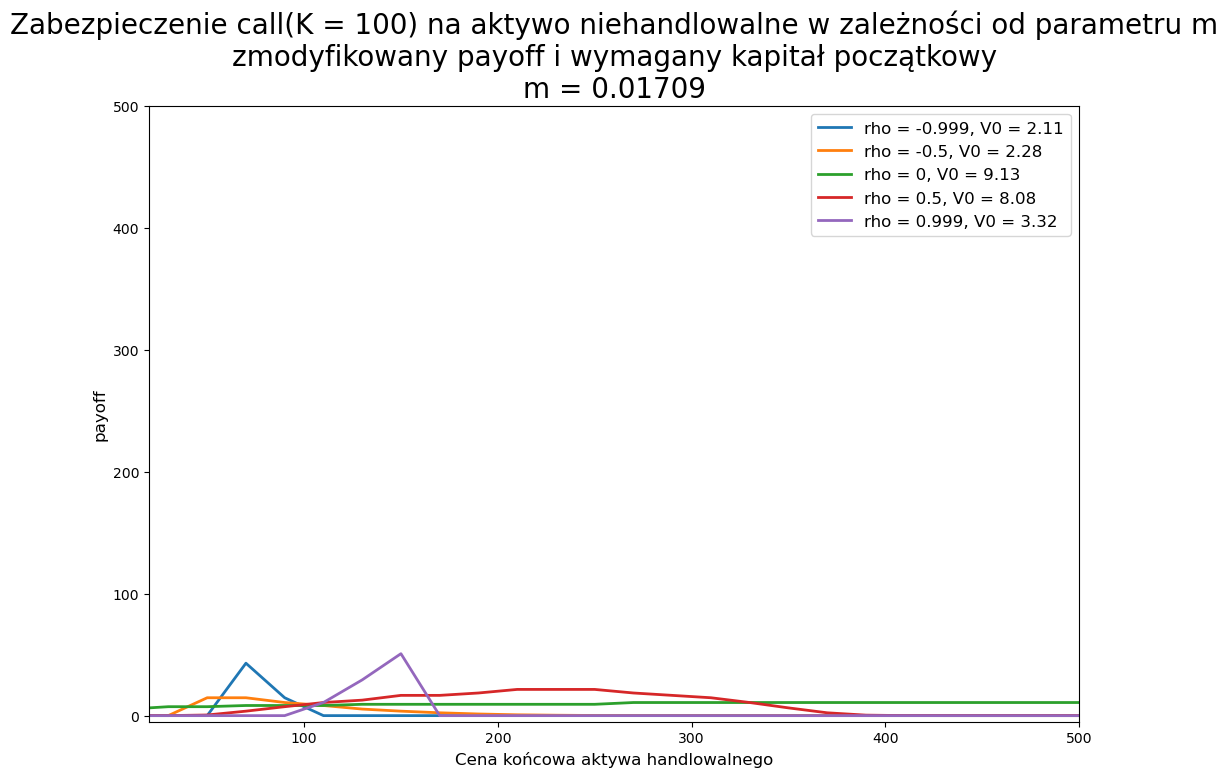

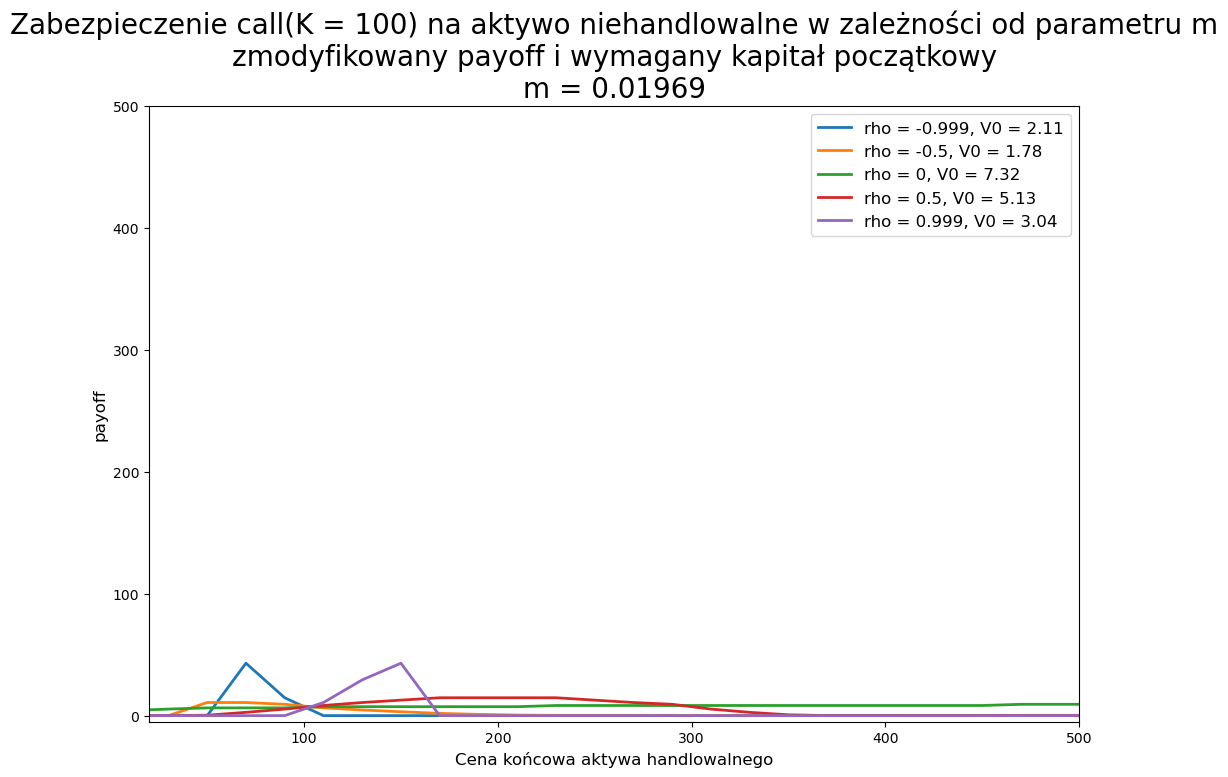

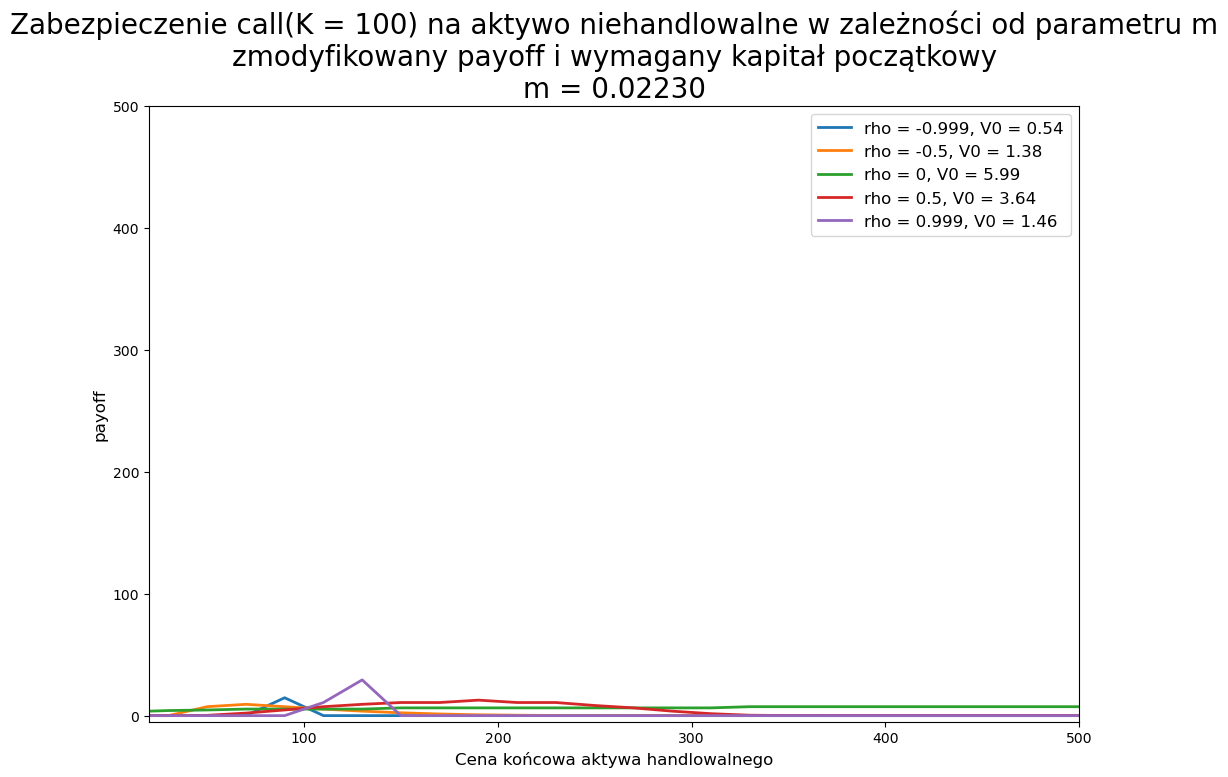

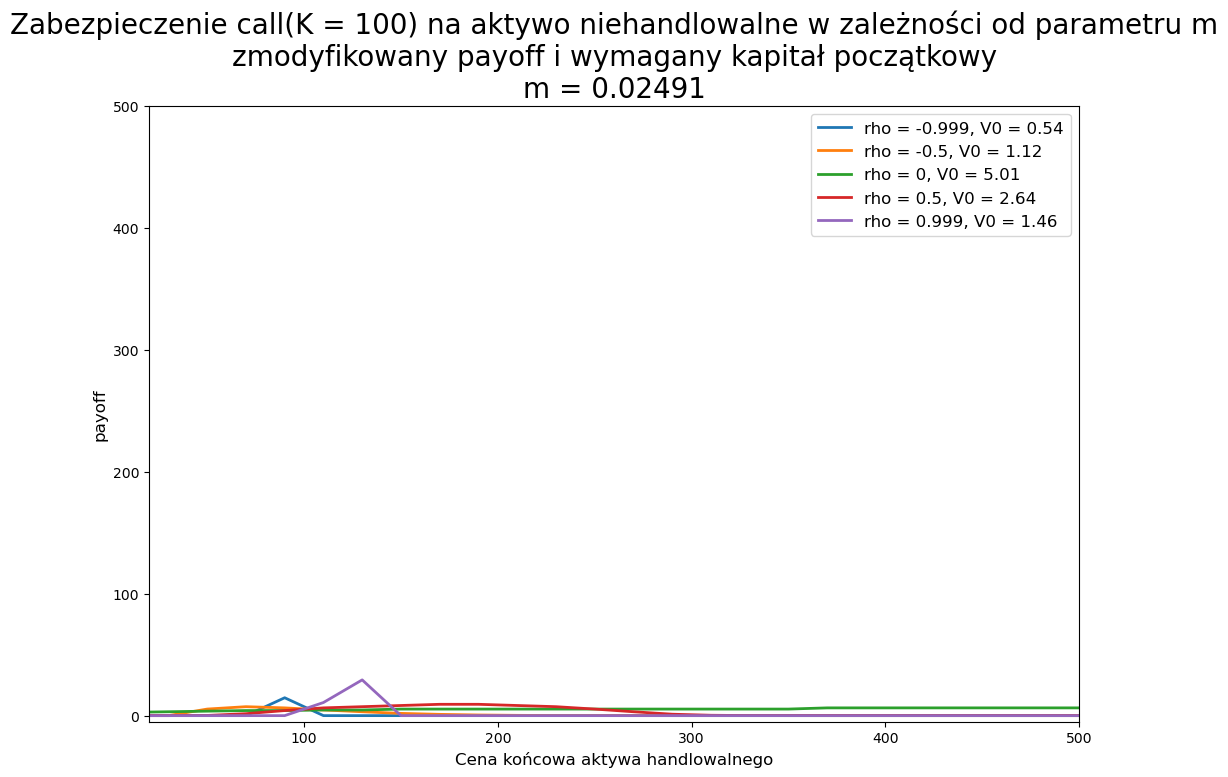

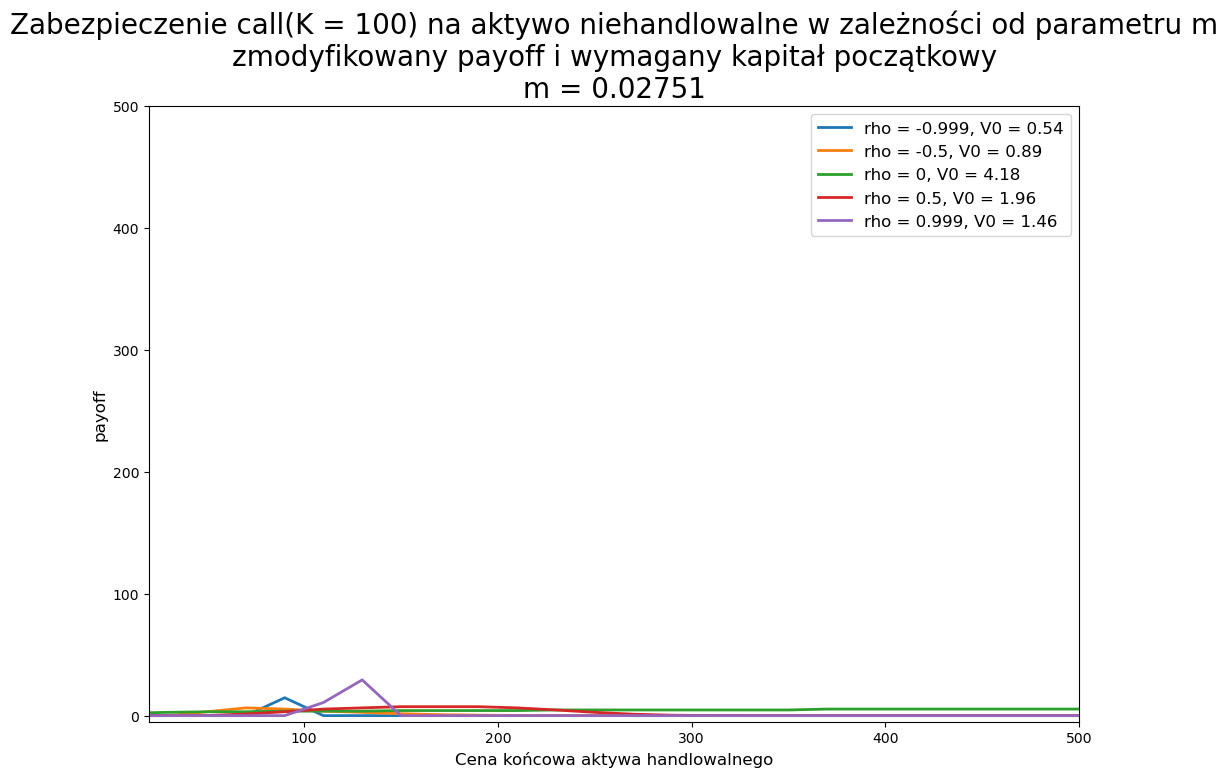

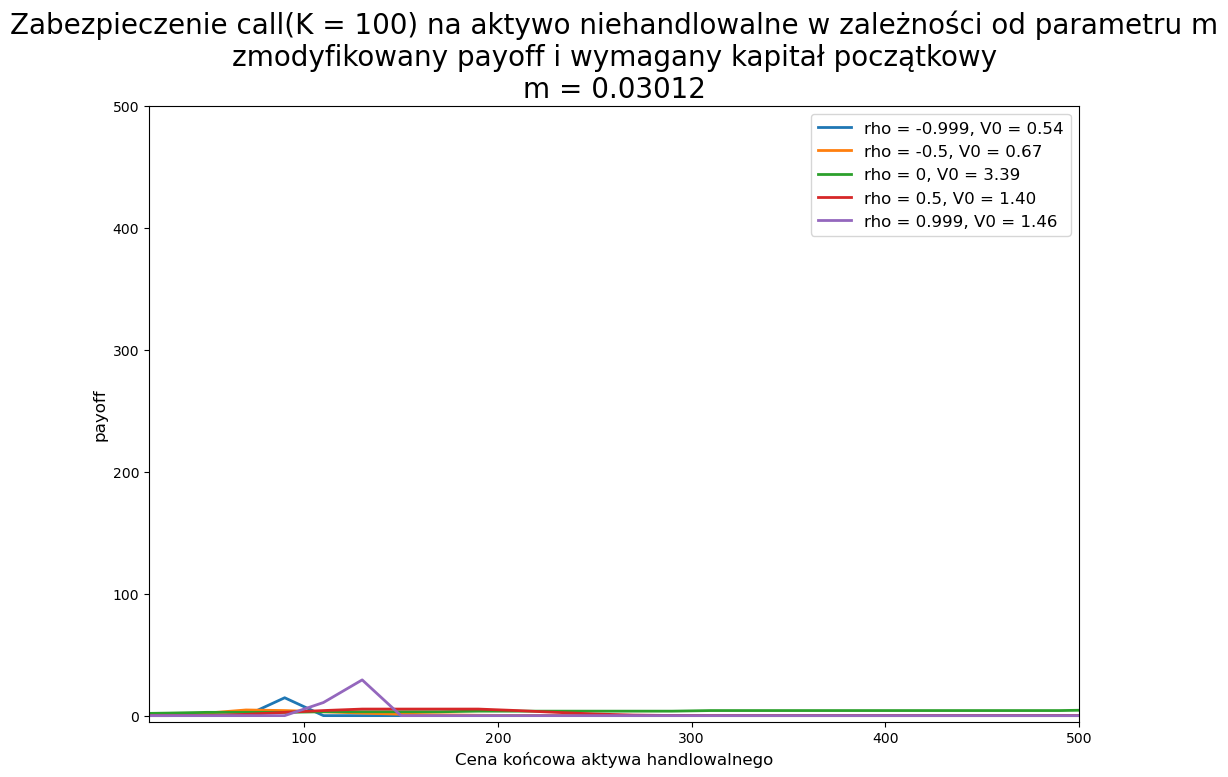

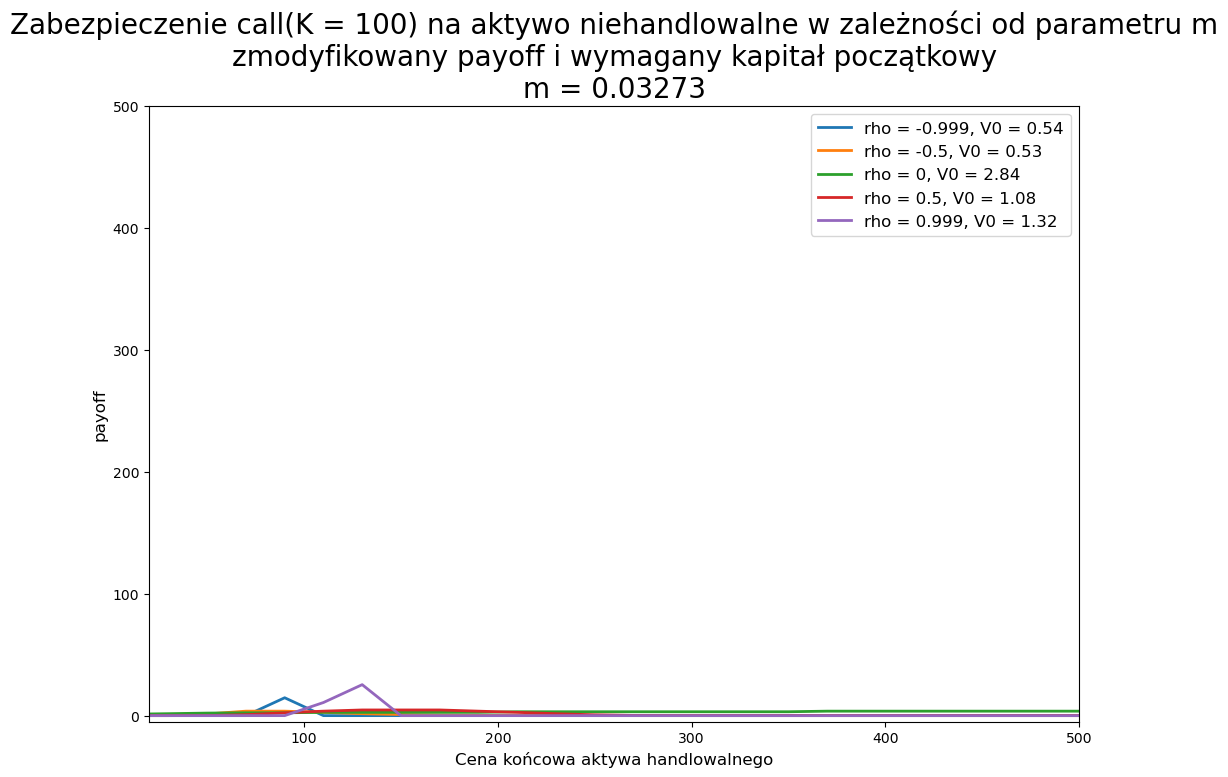

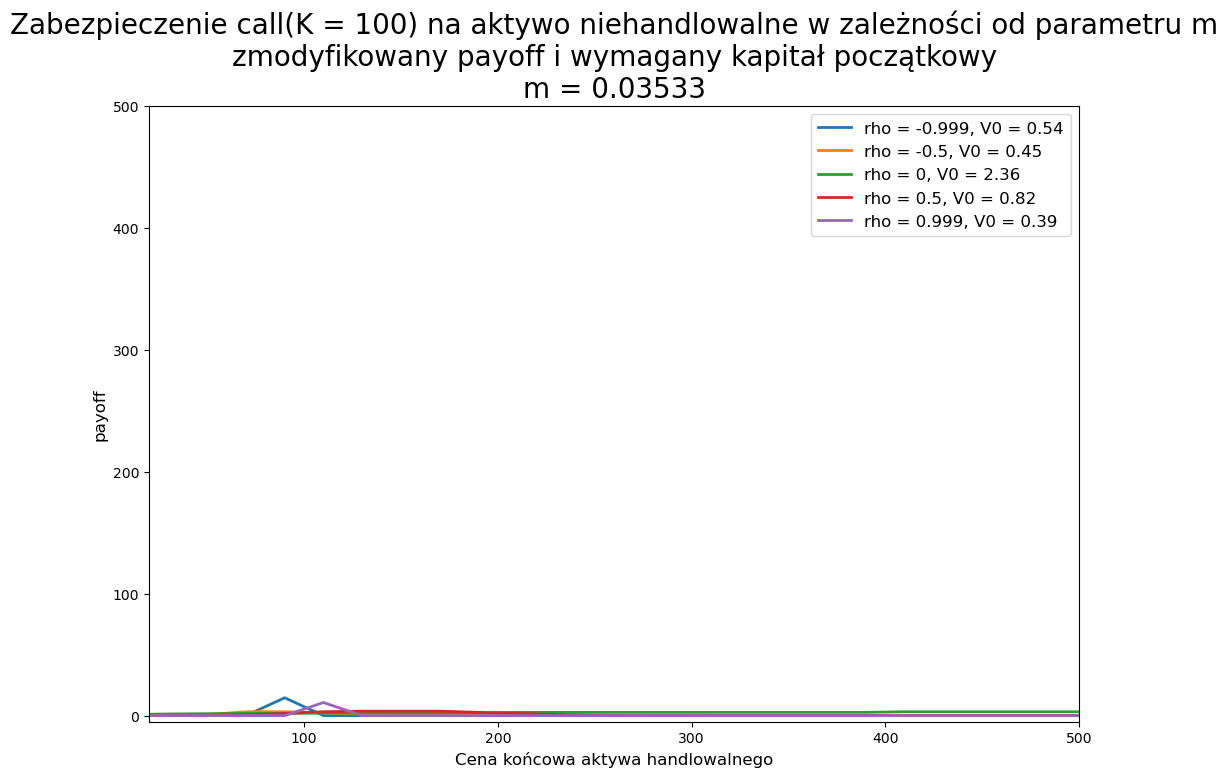

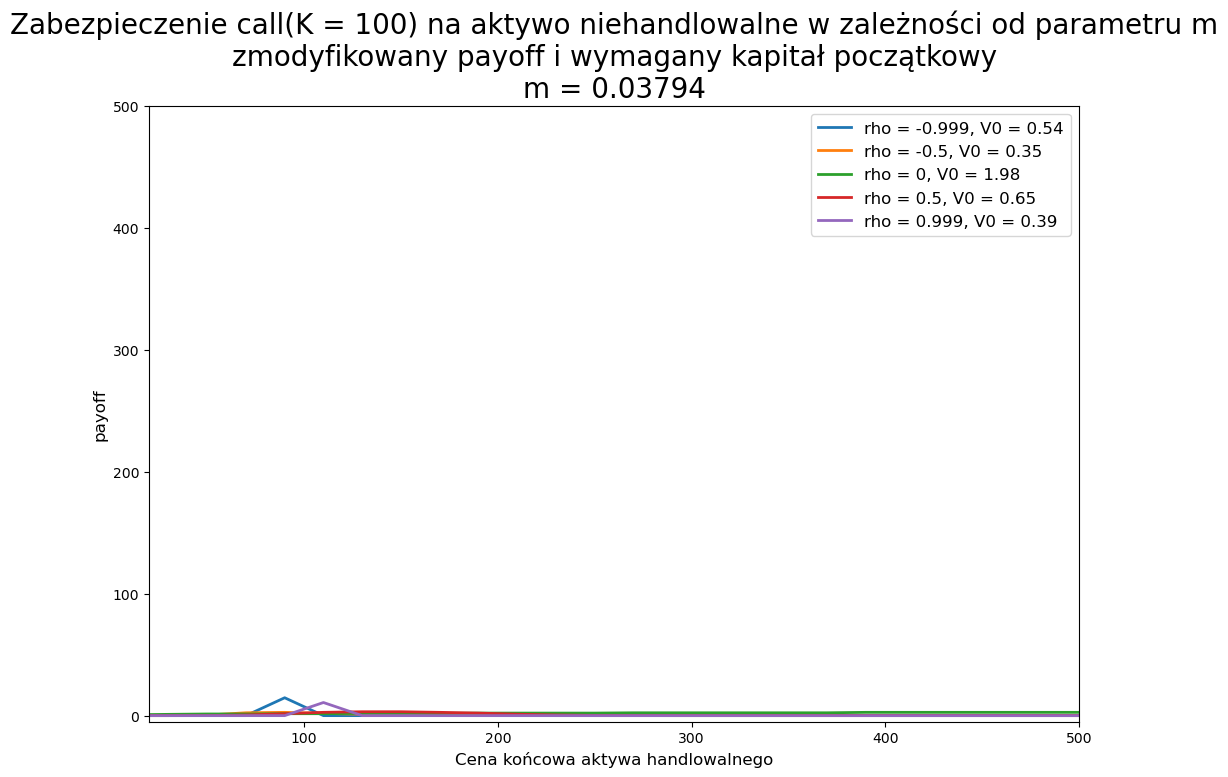

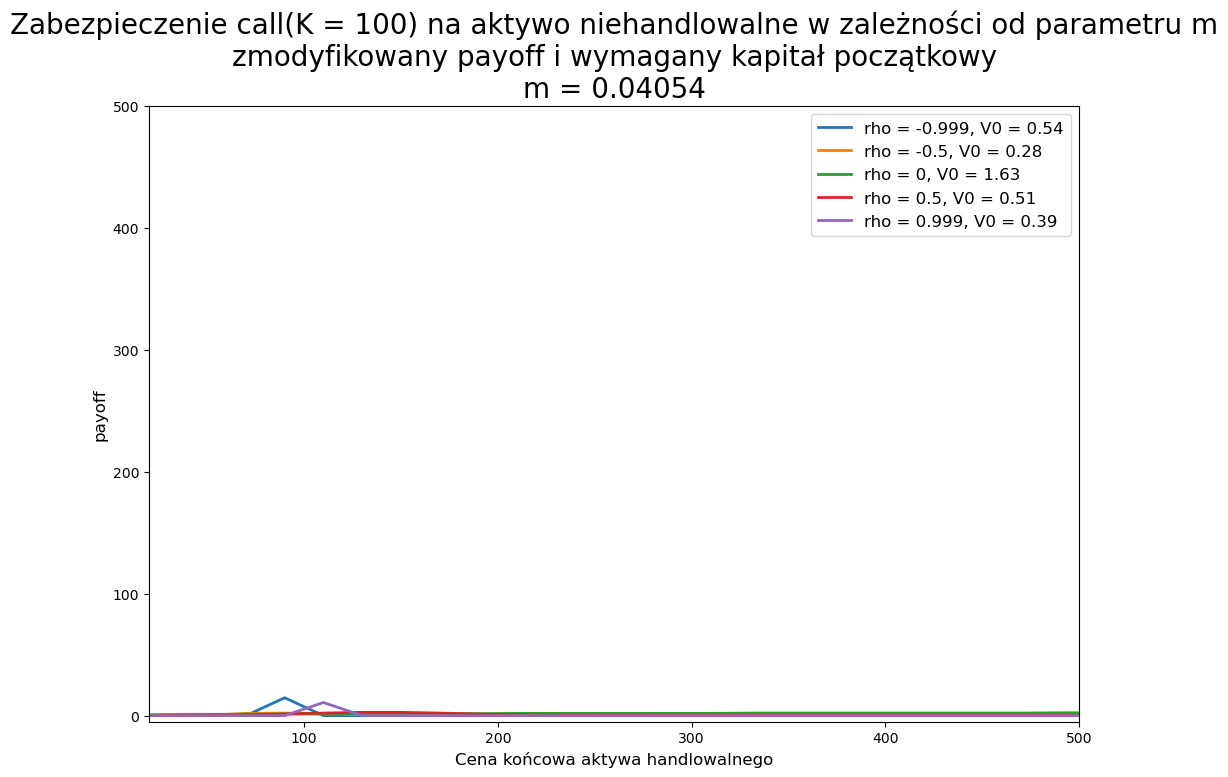

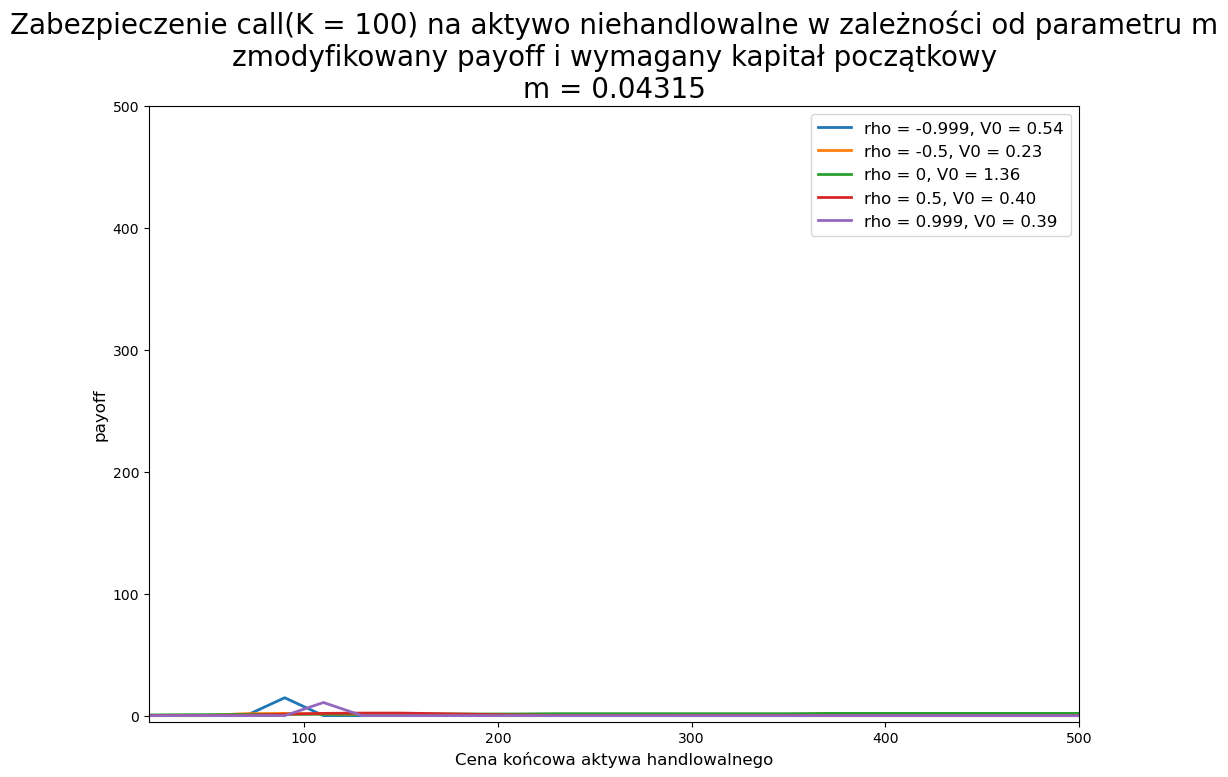

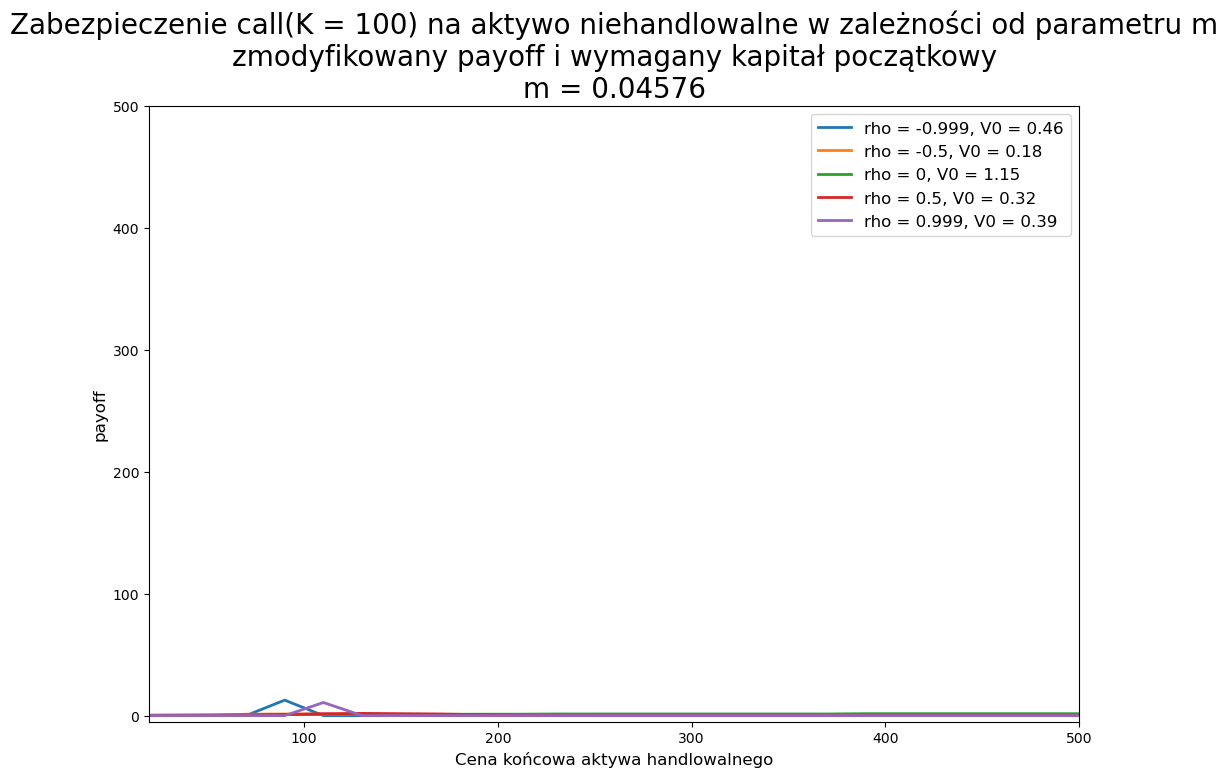

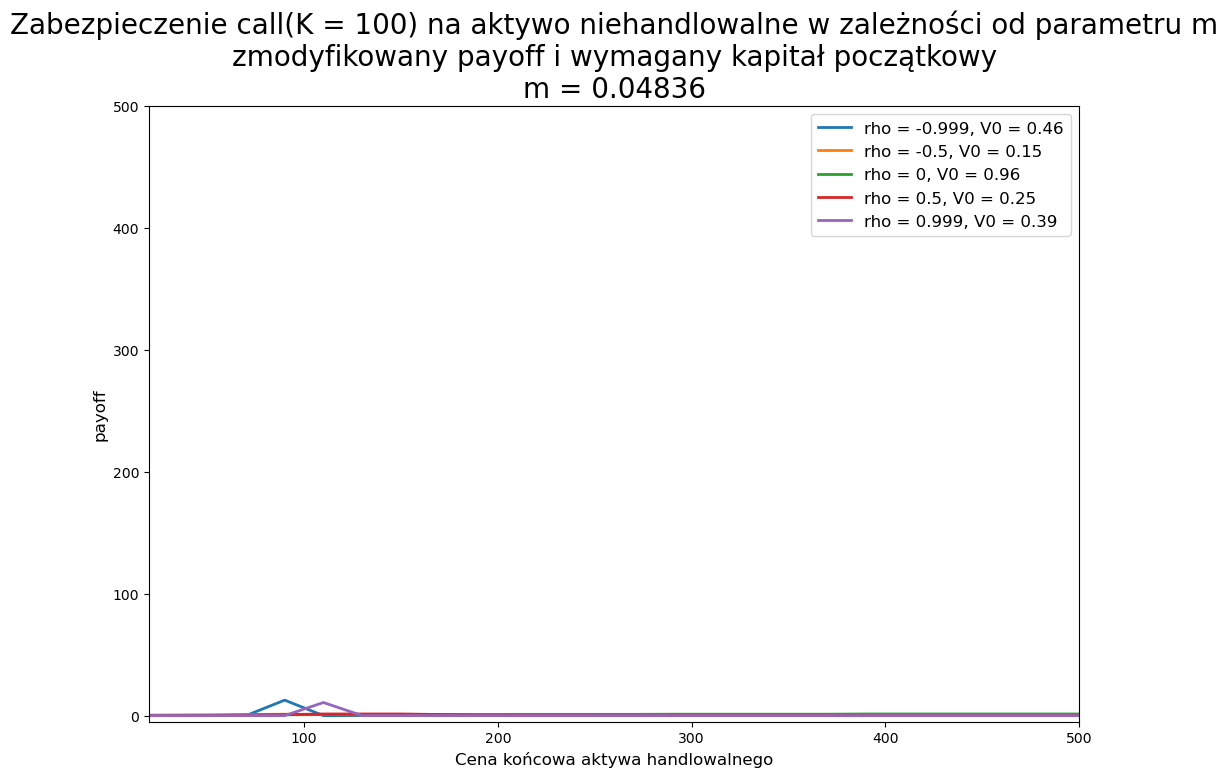

In [11]:
m = 0.0001
diff = 0.0002
rate = 1.9
V0_prev = len(rho_call) * [np.infty]
i = 0
j = 0
while True:
    j += 1
    plt.figure(figsize=(12,8))
    if j == 50:
        diff *= 3
    else:
        for num, rho in enumerate(rho_call):
            option = rho_call[rho]
            final_index = round(option.underlying.values_per_year * option.T + 1)
            sims_t = pd.DataFrame(np.ones(26), columns = [0])
            sims_t[1] = np.arange(10, 530, 20) / X0_t
            option.m = m
            payoff = option.payoff_special(X0_t * sims_t, X0_nt)
            V0 = np.exp(-option.underlying.r * option.T) * payoff.mean()
            if abs(V0 - V0_prev[num]) < 0.1:
                i += 1
            V0_prev[num] = V0
            plt.plot((X0_t * sims_t).iloc[:,-1], payoff, label = f'rho = {rho}, V0 = {V0:.2f}', lw = 2)
        plt.title(f'Zabezpieczenie call(K = {K}) na aktywo niehandlowalne w zależności od parametru m\nzmodyfikowany payoff i wymagany kapitał początkowy\nm = {m:.5f}', size = 20)
        plt.xlim([20,500])
        plt.xlabel('Cena końcowa aktywa handlowalnego', size = 12)
        plt.ylim([-5,500])
        plt.ylabel('payoff', size= 12)
        plt.legend(loc = 'upper right', prop={'size': 12})
    m += diff
    if i == 5:
        i = 0
        diff *= rate
    display.clear_output(wait = True)
    display.display(plt.gcf())
    if np.max(np.array(V0_prev)) < 1:
        break

In [15]:
rho_put = dict()
for rho in [-0.999, -0.5, 0, 0.5, 0.999]:
    underlying_nt = NonTradedUnderlying(mu_nt, sigma_nt, underlying_t, rho)
    rho_put[rho] = Vanilla_on_NonTraded(underlying_nt, K, T, False, 'success_ratio')

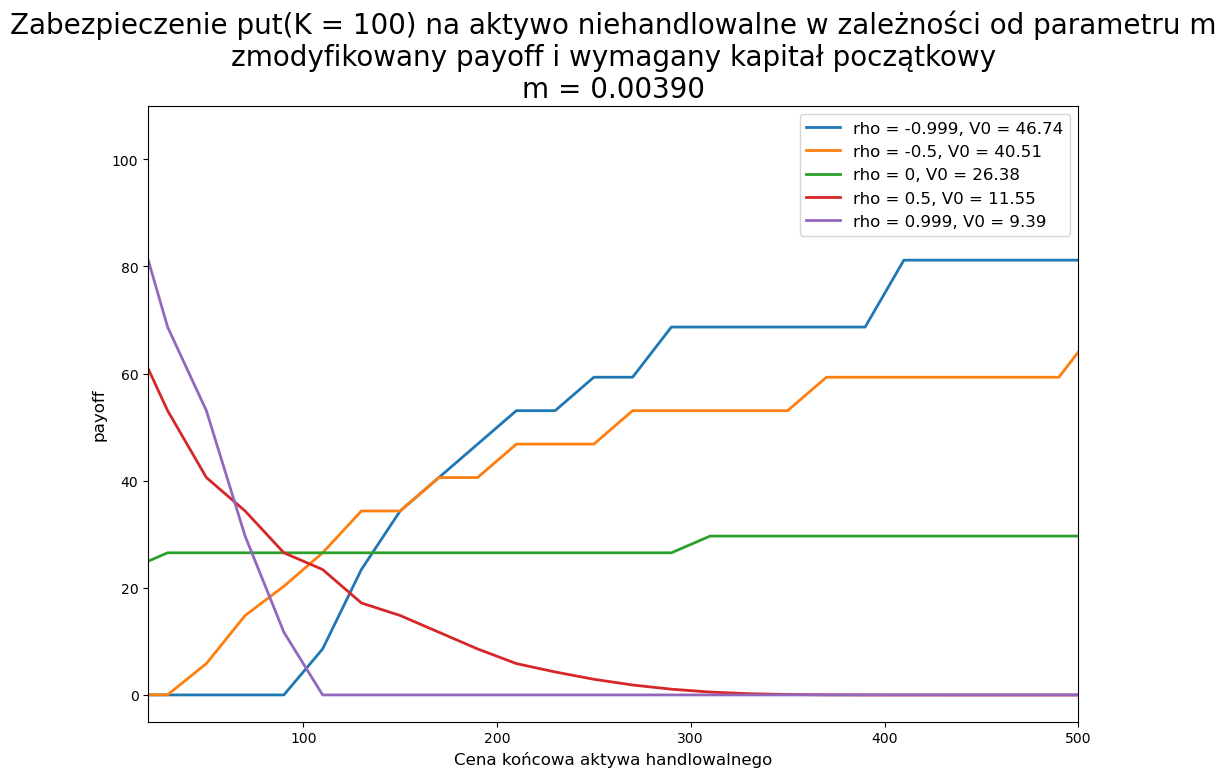

/var/folders/06/c8ym7n1n4pj6_wttc3cdtmnc0000gn/T/ipykernel_42188/1431389805.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,8))
/Users/Michal/Desktop/Quantile-Hedging/option.py:179: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 / np.sqrt(np.pi * 2 * T) / ( K - X0_nt * np.exp(mu_nt * T + sigma_nt * B_T * rho + np.sqrt(1 - rho ** 2) * sigma_nt * y - 0.5 * sigma_nt ** 2 * T)) * np.exp(y ** 2 / (-2 * T))
/Users/Michal/Desktop/Quantile-Hedging/option.py:188: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determ

KeyboardInterrupt: 

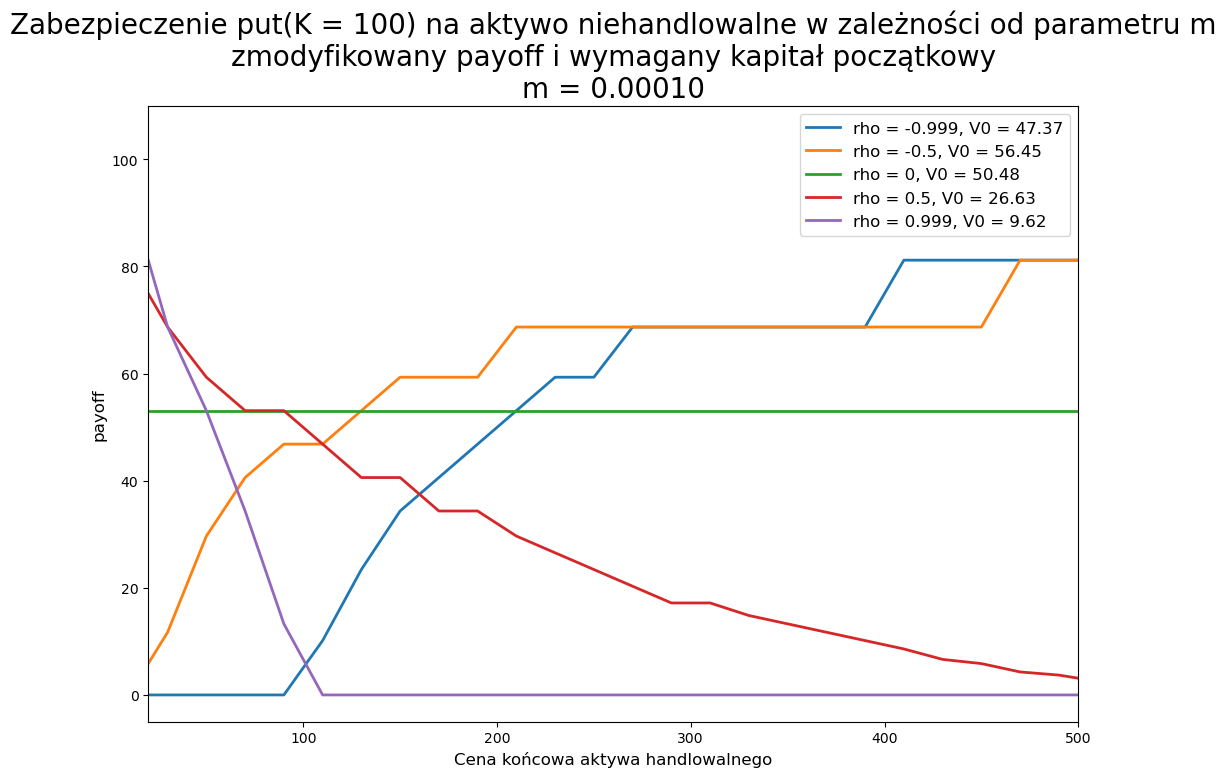

Error in callback <function flush_figures at 0x7fb7501241f0> (for post_execute):


KeyboardInterrupt: 

In [17]:
m = 0.0001
diff = 0.0002
rate = 1.9
V0_prev = len(rho_put) * [np.infty]
i = 0
j = 0
while True:
    j += 1
    plt.figure(figsize=(12,8))
    if j == 50:
        diff *= 3
    else:
        for num, rho in enumerate(rho_put):
            option = rho_put[rho]
            final_index = round(option.underlying.values_per_year * option.T + 1)
            sims_t = pd.DataFrame(np.ones(26), columns = [0])
            sims_t[1] = np.arange(10, 530, 20) / X0_t
            option.m = m
            payoff = option.payoff_special(X0_t * sims_t, X0_nt)
            V0 = np.exp(-option.underlying.r * option.T) * payoff.mean()
            if abs(V0 - V0_prev[num]) < 0.1:
                i += 1
            V0_prev[num] = V0
            plt.plot((X0_t * sims_t).iloc[:,-1], payoff, label = f'rho = {rho}, V0 = {V0:.2f}', lw = 2)
        plt.title(f'Zabezpieczenie put(K = {K}) na aktywo niehandlowalne w zależności od parametru m\nzmodyfikowany payoff i wymagany kapitał początkowy\nm = {m:.5f}', size = 20)
        plt.xlim([20,500])
        plt.xlabel('Cena końcowa aktywa handlowalnego', size = 12)
        plt.ylim([-5,110])
        plt.ylabel('payoff', size= 12)
        plt.legend(loc = 'upper right', prop={'size': 12})
    m += diff
    if i == 5:
        i = 0
        diff *= rate
    display.clear_output(wait = True)
    display.display(plt.gcf())
    if np.max(np.array(V0_prev)) < 1:
        break

In [11]:
call_nt = Vanilla_on_NonTraded(underlying_nt, K, T, True, 'success_ratio')

In [12]:
[_, reality_t], [_, reality_nt] = underlying_nt.simulate_together_P(repeat, T)

In [13]:
V0 = call_vanilla.get_price(X0_t)

In [24]:
fig, axs = plt.subplots(3,3, figsize = (15, 15), sharey = True)
fig.tight_layout(pad=5.0)
repeat = 1000
V0 = call_vanilla.get_price(X0_t)
for idx, rho in enumerate([0.99999, 0.5, 0]):
    underlying_nt = NonTradedUnderlying(mu_t, sigma_t, underlying_t, rho)
    [_, reality_t], [_, reality_nt] = underlying_nt.simulate_together_P(repeat, T)

    call_nt = Vanilla_on_NonTraded(underlying_nt, K, T, True, 'success_ratio')
    call_nt.set_m(V0, X0_t, X0_nt, precision = 1)
    sims_t = pd.DataFrame(np.ones(15), columns = [0])
    sims_t[1] = np.arange(50, 200, 10) / X0_t
    payoff = call_nt.payoff_special((X0_t * sims_t), X0_nt)

    money_time_call = pd.DataFrame(np.zeros(reality_t.shape))
    delta_time_call = pd.DataFrame(np.zeros(reality_t.shape))
    with Pool(8) as p:
            results = p.map(lambda i: trader_loop(i, call_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
    for num, item in enumerate(results):
        money_time_call.loc[num] = item[0]
        delta_time_call.loc[num] = item[1]   
    money_time_call_outcome = money_time_call.copy()
    money_time_call_outcome['outcome'] = money_time_call.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
    sb.histplot(ax = axs[0, idx], x = money_time_call_outcome[underlying_nt.values_per_year * T], bins = 10, hue = money_time_call_outcome['outcome'], palette = ['tab:blue','tab:orange'], legend = True, stat = 'density')
    axs[0, idx].set_title(f'rho = {rho}\nKońcowy stan portfela- histogram', fontsize = 10)
    axs[0, idx].set_xlabel('Końcowy stan portfela', fontsize = 10)
    axs[1, idx].plot((X0_t * sims_t).iloc[:,-1], payoff, lw = 3)
    axs[1, idx].set_title('Zmodyfikowany payoff dla aktywa handlowalnego', fontsize = 10)
    axs[1, idx].set_xlim([50,200])    
    axs[1, idx].set_xlabel('Końcowa cena aktywa handlowalnego')
    sb.scatterplot(ax = axs[2, idx], x = (X0_nt*reality_nt).iloc[:,-1], y = np.maximum((X0_nt*reality_nt)[underlying_nt.values_per_year * T] - K,0), hue = money_time_call_outcome['outcome'], palette = ['tab:blue','tab:orange']).set_title('Ostateczny payoff opcji')
    axs[2, idx].set_xlim([50,200])    
    axs[2, idx].set_xlabel('Końcowa cena aktywa niehandlowalnego', fontsize = 10)
    if idx == 0:
        axs[1, idx].set_ylabel('Payoff zmodyfikowany', fontsize = 10)    
        axs[2, idx].set_ylabel('Payoff zmodyfikowany', fontsize = 10)    
plt.suptitle('Quantile hedging opcji na aktywo niehandlowalne dla różnych korelacji z pomocniczym aktywem handlowalnym', fontsize= 15)
plt.subplots_adjust(top=0.92)


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fb7501241f0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
rho = 0.5
underlying_nt = NonTradedUnderlying(mu_t, sigma_t, underlying_t, rho)

In [ ]:
repeat = 1000

In [ ]:
[_, reality_t], [_, reality_nt] = underlying_nt.simulate_together_P(repeat, T)

In [ ]:
call_nt = Vanilla_on_NonTraded(underlying_nt, K, T, True)

In [ ]:
call_nt.set_m(V0, X0_t, X0_nt)

In [ ]:
payoffs2 = call_nt.payoff_special((X0_t * reality_t), X0_nt)

In [ ]:
money_time_call = pd.DataFrame(np.zeros(reality_t.shape))
delta_time_call = pd.DataFrame(np.zeros(reality_t.shape))
with Pool(8) as p:
        results = p.map(lambda i: trader_loop(i, call_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
for num, item in enumerate(results):
    money_time_call.loc[num] = item[0]
    delta_time_call.loc[num] = item[1]   
    money_time_call_outcome = money_time_call1.copy()
    money_time_call_outcome['outcome'] = money_time_call1.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
    plt.figure(figsize = (10, 5))
    sb.histplot(x = money_time_call_outcome[underlying_nt.values_per_year * T], bins = 20, hue = money_time_call_outcome['outcome'], legend = True, stat = 'density').set_title(f'Ostateczny stan portfela- wszystkie symulacje')

In [ ]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
indices = [(X0_t * reality_nt).iloc[:,-1].idxmax(),(X0_t * reality_nt).iloc[:,-1].idxmin(), abs((X0_t * reality_nt).iloc[:,-1] - K).idxmin()]
(X0_nt*reality_nt.iloc[indices,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny niehandlowalnego aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,values_per_year])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
axs[0].set_xlabel('t')
axs[0].set_ylabel('Cena aktywa niehandlowalnego')
(money_time_call.iloc[indices,:]).T.plot(legend = False, ax = axs[1], title = f'Ilość posiadanej gotówki zabezpieczenia call(K = {K}) w czasie')
axs[1].set_xlim([0,values_per_year])
axs[1].set_xlabel('t')
axs[1].set_ylabel('Ilość posiadanej gotówki')
(delta_time_call.iloc[indices,:]).T.plot(legend = False, ax = axs[2], title = f'Ilość posiadanego aktywa handlowalnego zabezpieczania call(K = {K}) w czasie')
axs[2].set_xlim([0,values_per_year])
axs[2].set_xlabel('t')
axs[1].set_ylabel('Ilość posiadanego aktywa handlowalnego')

In [ ]:
plt.figure(figsize = (10,10))
sb.histplot(money_time_call.iloc[:,-1], bins = 50, stat = 'density').set(xlim = [np.min(money_time_call.iloc[:,-1]) - 5, np.max(money_time_call.iloc[:,-1]) + 5], title = f'Hedging kwantylowy aktywa niehandlowalnego o identycznym aktywie handlowalnym\nKońcowa wartość portfela\nmean = {money_time_call.iloc[:,-1].mean():.3f}, std = {money_time_call.iloc[:,-1].std():.3f}')

In [ ]:
put_nt = Vanilla_on_NonTraded(underlying_nt, K, T, False)

In [ ]:
V0 = put_nt.get_MC_price(X0_t, X0_nt) / 2

In [ ]:
V0

In [ ]:
put_nt.set_m(V0, X0_t, X0_nt)

In [ ]:
plt.scatter((X0_t * reality_t).iloc[:,-1], put_nt.payoff_special((X0_t * reality_t), X0_nt))

In [ ]:
money_time_put = pd.DataFrame(np.zeros(reality_t.shape))
delta_time_put = pd.DataFrame(np.zeros(reality_t.shape))
with Pool(8) as p:
        results = p.map(lambda i: trader_loop(i, put_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
for num, item in enumerate(results):
    money_time_put.loc[num] = item[0]
    delta_time_put.loc[num] = item[1]   

In [ ]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
indices = [(X0_t * reality_nt).iloc[:,-1].idxmax(),(X0_t * reality_nt).iloc[:,-1].idxmin(), abs((X0_t * reality_nt).iloc[:,-1] - K).idxmin()]
(X0_nt*reality_nt.iloc[indices,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny niehandlowalnego aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,values_per_year])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
axs[0].set_xlabel('t')
axs[0].set_ylabel('Cena aktywa niehandlowalnego')
(money_time_put.iloc[indices,:]).T.plot(legend = False, ax = axs[1], title = f'Ilość posiadanej gotówki zabezpieczenia put(K = {K}) w czasie')
axs[1].set_xlim([0,values_per_year])
axs[1].set_xlabel('t')
axs[1].set_ylabel('Ilość posiadanej gotówki')
(delta_time_put.iloc[indices,:]).T.plot(legend = False, ax = axs[2], title = f'Ilość posiadanego aktywa handlowalnego zabezpieczania put(K = {K}) w czasie')
axs[2].set_xlim([0,values_per_year])
axs[2].set_xlabel('t')
axs[1].set_ylabel('Ilość posiadanego aktywa handlowalnego')

In [ ]:
plt.figure(figsize = (10,10))
sb.histplot(money_time_put.iloc[:,-1], bins = 50, stat = 'density').set(xlim = [np.min(money_time_put.iloc[:,-1]) - 5, np.max(money_time_put.iloc[:,-1]) + 5], title = f'Hedging kwantylowy aktywa niehandlowalnego o identycznym aktywie handlowalnym\nKońcowa wartość portfela\nmean = {money_time_put.iloc[:,-1].mean():.3f}, std = {money_time_put.iloc[:,-1].std():.3f}')

In [ ]:
rho = 0.75
underlying_nt = NonTradedUnderlying(mu_t, sigma_t, underlying_t, rho)

In [ ]:
repeat = 1000

In [ ]:
[_, reality_t], [_, reality_nt] = underlying_nt.simulate_together_Q(repeat, T)

In [ ]:
call_nt = Vanilla_on_NonTraded(underlying_nt, K, T, True)
put_nt = Vanilla_on_NonTraded(underlying_nt, K, T, False)

In [ ]:
V0 = call_nt.get_MC_price(X0_t, X0_nt)

In [ ]:
plt.scatter((X0_t * reality_t).iloc[:,-1], call_nt.payoff_special((X0_t * reality_t), X0_nt))

In [ ]:
money_time_call1 = pd.DataFrame(np.zeros(reality_t.shape))
delta_time_call1 = pd.DataFrame(np.zeros(reality_t.shape))
with Pool(8) as p:
        results = p.map(lambda i: trader_loop(i, call_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
for num, item in enumerate(results):
    money_time_call1.loc[num] = item[0]
    delta_time_call1.loc[num] = item[1]   

In [ ]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
indices = [(X0_t * reality_nt).iloc[:,-1].idxmax(),(X0_t * reality_nt).iloc[:,-1].idxmin(), abs((X0_t * reality_nt).iloc[:,-1] - K).idxmin()]
(X0_nt*reality_nt.iloc[indices,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny niehandlowalnego aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,values_per_year])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_call1.iloc[indices,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,values_per_year])
(delta_time_call1.iloc[indices,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,values_per_year])

In [ ]:
plt.figure(figsize = (10,10))
sb.histplot(money_time_call1.iloc[:,-1], bins = 50, stat = 'density').set(xlim = [np.min(money_time_call.iloc[:,-1]) - 5, np.max(money_time_call.iloc[:,-1]) + 5], title = f'Dopasowany do V0 hedging kwantylowy\n mean = {money_time_call.iloc[:,-1].mean():.3f}, std = {money_time_call.iloc[:,-1].std():.3f}')

In [ ]:
money_time_call_outcome = money_time_call1.copy()
money_time_call_outcome['outcome'] = money_time_call1.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
plt.figure(figsize = (10, 5))
sb.histplot(x = money_time_call_outcome[underlying_nt.values_per_year * T], bins = 20, hue = money_time_call_outcome['outcome'], legend = True, stat = 'density').set_title(f'Ostateczny stan portfela- wszystkie symulacje')

In [ ]:
call_nt = Vanilla_on_NonTraded(underlying_nt, K, T, True)

In [ ]:
V0 = 1

In [ ]:
old_diff = np.infty
step = 0.00001
for m in np.arange(0.00001, 1, step):
    call_nt.m = m
    price = call_nt.get_MC_price(X0_t, X0_nt)
    diff = abs(price - V0)
    if diff > old_diff:
        break
    old_diff = diff
call_nt.m = m - step

In [ ]:
plt.scatter((X0_t * reality_t).iloc[:,-1], call_nt.payoff_special((X0_t * reality_t), X0_nt))

In [ ]:
money_time_call = pd.DataFrame(np.zeros(reality_t.shape))
delta_time_call = pd.DataFrame(np.zeros(reality_t.shape))
with Pool(8) as p:
        results = p.map(lambda i: trader_loop(i, call_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
for num, item in enumerate(results):
    money_time_call.loc[num] = item[0]
    delta_time_call.loc[num] = item[1]   

In [ ]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
(X0_nt*reality_nt.iloc[:10,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,values_per_year])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_call.iloc[:10,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,values_per_year])
(delta_time_call.iloc[:10,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,values_per_year])

In [ ]:
plt.figure(figsize = (10,10))
sb.histplot(money_time_call.iloc[:,-1], bins = 50, stat = 'density').set(xlim = [np.min(money_time_call.iloc[:,-1]) - 5, np.max(money_time_call.iloc[:,-1]) + 5], title = f'Dopasowany do V0 hedging kwantylowy\n mean = {money_time_call.iloc[:,-1].mean():.3f}, std = {money_time_call.iloc[:,-1].std():.3f}')

In [ ]:
money_time_call_outcome = money_time_call.copy()
money_time_call_outcome['outcome'] = money_time_call.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
plt.figure(figsize = (10, 5))
sb.histplot(x = money_time_call_outcome[underlying_nt.values_per_year * T], bins = 20, hue = money_time_call_outcome['outcome'], legend = True, stat = 'density').set_title(f'Ostateczny stan portfela- wszystkie symulacje')

In [ ]:
V0 = 10

In [ ]:
old_diff = np.infty
step = 0.00001
for m in np.arange(0.00001, 1, step):
    put_nt.m = m
    price = put_nt.get_MC_price(X0_t, X0_nt)
    diff = abs(price - V0)
    if diff > old_diff:
        break
    old_diff = diff
put_nt.m = m - step

In [ ]:
plt.scatter((X0_t * reality_t).iloc[:,-1], put_nt.payoff_special((X0_t * reality_t), X0_nt))

In [ ]:
money_time_put = pd.DataFrame(np.zeros(reality_t.shape))
delta_time_put = pd.DataFrame(np.zeros(reality_t.shape))
with Pool(8) as p:
        results = p.map(lambda i: trader_loop(i, put_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
for num, item in enumerate(results):
    money_time_put.loc[num] = item[0]
    delta_time_put.loc[num] = item[1]   

In [ ]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
(X0_nt*reality_nt.iloc[:10,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,values_per_year])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_put.iloc[:10,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,values_per_year])
(delta_time_put.iloc[:10,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,values_per_year])

In [ ]:
plt.figure(figsize = (10,10))
sb.histplot(money_time_put.iloc[:,-1], bins = 50, stat = 'density').set(xlim = [np.min(money_time_put.iloc[:,-1]) - 5, np.max(money_time_put.iloc[:,-1]) + 5], title = f'Dopasowany do V0 hedging kwantylowy\n mean = {money_time_put.iloc[:,-1].mean():.3f}, std = {money_time_put.iloc[:,-1].std():.3f}')

In [ ]:
money_time_put_outcome = money_time_put.copy()
money_time_put_outcome['outcome'] = money_time_put.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
plt.figure(figsize = (10, 5))
sb.histplot(x = money_time_put_outcome[underlying_nt.values_per_year * T], bins = 20, hue = money_time_put_outcome['outcome'], legend = True, stat = 'density').set_title(f'Ostateczny stan portfela- wszystkie symulacje')

In [ ]:
put_nt = Vanilla_on_NonTraded(underlying_nt, K, T, False)

In [ ]:
V0 = 1

In [ ]:
old_diff = np.infty
step = 0.00001
for m in np.arange(0.00001, 1, step):
    put_nt.m = m
    price = put_nt.get_MC_price(X0_t, X0_nt)
    diff = abs(price - V0)
    if diff > old_diff:
        break
    old_diff = diff
put_nt.m = m - step

In [ ]:
plt.scatter((X0_t * reality_t).iloc[:,-1], put_nt.payoff_special((X0_t * reality_t), X0_nt))

In [ ]:
money_time_put = pd.DataFrame(np.zeros(reality_t.shape))
delta_time_put = pd.DataFrame(np.zeros(reality_t.shape))
with Pool(8) as p:
        results = p.map(lambda i: trader_loop(i, put_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
for num, item in enumerate(results):
    money_time_put.loc[num] = item[0]
    delta_time_put.loc[num] = item[1]   

In [ ]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
(X0_nt*reality_nt.iloc[:10,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,values_per_year])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_put.iloc[:10,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,values_per_year])
(delta_time_put.iloc[:10,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,values_per_year])

In [ ]:
plt.figure(figsize = (10,10))
sb.histplot(money_time_put.iloc[:,-1], bins = 50, stat = 'density').set(xlim = [np.min(money_time_put.iloc[:,-1]) - 5, np.max(money_time_put.iloc[:,-1]) + 5], title = f'Dopasowany do V0 hedging kwantylowy\n mean = {money_time_put.iloc[:,-1].mean():.3f}, std = {money_time_put.iloc[:,-1].std():.3f}')

In [ ]:
money_time_put_outcome = money_time_put.copy()
money_time_put_outcome['outcome'] = money_time_put.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
plt.figure(figsize = (10, 5))
sb.histplot(x = money_time_put_outcome[underlying_nt.values_per_year * T], bins = 20, hue = money_time_put_outcome['outcome'], legend = True, stat = 'density').set_title(f'Ostateczny stan portfela- wszystkie symulacje')

In [ ]:
rho = -0.75
underlying_nt = NonTradedUnderlying(mu_t, sigma_t, underlying_t, rho)

In [ ]:
repeat = 1000

In [ ]:
[_, reality_t], [_, reality_nt] = underlying_nt.simulate_together_Q(repeat, T)

In [ ]:
call_nt = Vanilla_on_NonTraded(underlying_nt, K, T, True)
put_nt = Vanilla_on_NonTraded(underlying_nt, K, T, False)

In [ ]:
V0 = 10

In [ ]:
old_diff = np.infty
step = 0.00001
for m in np.arange(0.00001, 1, step):
    call_nt.m = m
    price = call_nt.get_MC_price(X0_t, X0_nt)
    diff = abs(price - V0)
    if diff > old_diff:
        break
    old_diff = diff
call_nt.m = m - step

In [ ]:
plt.scatter((X0_t * reality_t).iloc[:,-1], call_nt.payoff_special((X0_t * reality_t), X0_nt))

In [ ]:
money_time_call = pd.DataFrame(np.zeros(reality_t.shape))
delta_time_call = pd.DataFrame(np.zeros(reality_t.shape))
with Pool(8) as p:
        results = p.map(lambda i: trader_loop(i, call_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
for num, item in enumerate(results):
    money_time_call.loc[num] = item[0]
    delta_time_call.loc[num] = item[1]   

In [ ]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
(X0_nt*reality_nt.iloc[:10,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,values_per_year])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_call.iloc[:10,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,values_per_year])
(delta_time_call.iloc[:10,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,values_per_year])

In [ ]:
plt.figure(figsize = (10,10))
sb.histplot(money_time_call.iloc[:,-1], bins = 50, stat = 'density').set(xlim = [np.min(money_time_call.iloc[:,-1]) - 5, np.max(money_time_call.iloc[:,-1]) + 5], title = f'Dopasowany do V0 hedging kwantylowy\n mean = {money_time_call.iloc[:,-1].mean():.3f}, std = {money_time_call.iloc[:,-1].std():.3f}')

In [ ]:
money_time_call_outcome = money_time_call.copy()
money_time_call_outcome['outcome'] = money_time_call.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
plt.figure(figsize = (10, 5))
sb.histplot(x = money_time_call_outcome[underlying_nt.values_per_year * T], bins = 20, hue = money_time_call_outcome['outcome'], legend = True, stat = 'density').set_title(f'Ostateczny stan portfela- wszystkie symulacje')

In [ ]:
call_nt = Vanilla_on_NonTraded(underlying_nt, K, T, True)

In [ ]:
V0 = 1

In [ ]:
old_diff = np.infty
step = 0.00001
for m in np.arange(0.00001, 1, step):
    call_nt.m = m
    price = call_nt.get_MC_price(X0_t, X0_nt)
    diff = abs(price - V0)
    if diff > old_diff:
        break
    old_diff = diff
call_nt.m = m - step

In [ ]:
plt.scatter((X0_t * reality_t).iloc[:,-1], call_nt.payoff_special((X0_t * reality_t), X0_nt))

In [ ]:
money_time_call = pd.DataFrame(np.zeros(reality_t.shape))
delta_time_call = pd.DataFrame(np.zeros(reality_t.shape))
with Pool(8) as p:
        results = p.map(lambda i: trader_loop(i, call_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
for num, item in enumerate(results):
    money_time_call.loc[num] = item[0]
    delta_time_call.loc[num] = item[1]   

In [ ]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
(X0_nt*reality_nt.iloc[:10,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,values_per_year])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_call.iloc[:10,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,values_per_year])
(delta_time_call.iloc[:10,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,values_per_year])

In [ ]:
plt.figure(figsize = (10,10))
sb.histplot(money_time_call.iloc[:,-1], bins = 50, stat = 'density').set(xlim = [np.min(money_time_call.iloc[:,-1]) - 5, np.max(money_time_call.iloc[:,-1]) + 5], title = f'Dopasowany do V0 hedging kwantylowy\n mean = {money_time_call.iloc[:,-1].mean():.3f}, std = {money_time_call.iloc[:,-1].std():.3f}')

In [ ]:
money_time_call_outcome = money_time_call.copy()
money_time_call_outcome['outcome'] = money_time_call.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
plt.figure(figsize = (10, 5))
sb.histplot(x = money_time_call_outcome[underlying_nt.values_per_year * T], bins = 20, hue = money_time_call_outcome['outcome'], legend = True, stat = 'density').set_title(f'Ostateczny stan portfela- wszystkie symulacje')

In [ ]:
V0 = 10

In [ ]:
old_diff = np.infty
step = 0.00001
for m in np.arange(0.00001, 1, step):
    put_nt.m = m
    price = put_nt.get_MC_price(X0_t, X0_nt)
    diff = abs(price - V0)
    if diff > old_diff:
        break
    old_diff = diff
put_nt.m = m - step

In [ ]:
plt.scatter((X0_t * reality_t).iloc[:,-1], put_nt.payoff_special((X0_t * reality_t), X0_nt))

In [ ]:
money_time_put = pd.DataFrame(np.zeros(reality_t.shape))
delta_time_put = pd.DataFrame(np.zeros(reality_t.shape))
with Pool(8) as p:
        results = p.map(lambda i: trader_loop(i, put_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
for num, item in enumerate(results):
    money_time_put.loc[num] = item[0]
    delta_time_put.loc[num] = item[1]   

In [ ]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
(X0_nt*reality_nt.iloc[:10,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,values_per_year])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_put.iloc[:10,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,values_per_year])
(delta_time_put.iloc[:10,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,values_per_year])

In [ ]:
plt.figure(figsize = (10,10))
sb.histplot(money_time_put.iloc[:,-1], bins = 50, stat = 'density').set(xlim = [np.min(money_time_put.iloc[:,-1]) - 5, np.max(money_time_put.iloc[:,-1]) + 5], title = f'Dopasowany do V0 hedging kwantylowy\n mean = {money_time_put.iloc[:,-1].mean():.3f}, std = {money_time_put.iloc[:,-1].std():.3f}')

In [ ]:
money_time_put_outcome = money_time_put.copy()
money_time_put_outcome['outcome'] = money_time_put.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
plt.figure(figsize = (10, 5))
sb.histplot(x = money_time_put_outcome[underlying_nt.values_per_year * T], bins = 20, hue = money_time_put_outcome['outcome'], legend = True, stat = 'density').set_title(f'Ostateczny stan portfela- wszystkie symulacje')

In [ ]:
put_nt = Vanilla_on_NonTraded(underlying_nt, K, T, False)

In [ ]:
V0 = 1

In [ ]:
old_diff = np.infty
step = 0.00001
for m in np.arange(0.00001, 1, step):
    put_nt.m = m
    price = put_nt.get_MC_price(X0_t, X0_nt)
    diff = abs(price - V0)
    if diff > old_diff:
        break
    old_diff = diff
put_nt.m = m - step

In [ ]:
plt.scatter((X0_t * reality_t).iloc[:,-1], put_nt.payoff_special((X0_t * reality_t), X0_nt))

In [ ]:
money_time_put = pd.DataFrame(np.zeros(reality_t.shape))
delta_time_put = pd.DataFrame(np.zeros(reality_t.shape))
with Pool(8) as p:
        results = p.map(lambda i: trader_loop(i, put_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
for num, item in enumerate(results):
    money_time_put.loc[num] = item[0]
    delta_time_put.loc[num] = item[1]   

In [ ]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
(X0_nt*reality_nt.iloc[:10,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,values_per_year])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_put.iloc[:10,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,values_per_year])
(delta_time_put.iloc[:10,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,values_per_year])

In [ ]:
plt.figure(figsize = (10,10))
sb.histplot(money_time_put.iloc[:,-1], bins = 50, stat = 'density').set(xlim = [np.min(money_time_put.iloc[:,-1]) - 5, np.max(money_time_put.iloc[:,-1]) + 5], title = f'Dopasowany do V0 hedging kwantylowy\n mean = {money_time_put.iloc[:,-1].mean():.3f}, std = {money_time_put.iloc[:,-1].std():.3f}')

In [ ]:
money_time_put_outcome = money_time_put.copy()
money_time_put_outcome['outcome'] = money_time_put.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
plt.figure(figsize = (10, 5))
sb.histplot(x = money_time_put_outcome[underlying_nt.values_per_year * T], bins = 20, hue = money_time_put_outcome['outcome'], legend = True, stat = 'density').set_title(f'Ostateczny stan portfela- wszystkie symulacje')

In [ ]:
rho = 0.25
underlying_nt = NonTradedUnderlying(mu_t, sigma_t, underlying_t, rho)

In [ ]:
repeat = 1000

In [ ]:
[_, reality_t], [_, reality_nt] = underlying_nt.simulate_together_Q(repeat, T)

In [ ]:
call_nt = Vanilla_on_NonTraded(underlying_nt, K, T, True)
put_nt = Vanilla_on_NonTraded(underlying_nt, K, T, False)

In [ ]:
V0 = 10

In [ ]:
old_diff = np.infty
step = 0.00001
for m in np.arange(0.00001, 1, step):
    call_nt.m = m
    price = call_nt.get_MC_price(X0_t, X0_nt)
    diff = abs(price - V0)
    if diff > old_diff:
        break
    old_diff = diff
call_nt.m = m - step

In [ ]:
plt.scatter((X0_t * reality_t).iloc[:,-1], call_nt.payoff_special((X0_t * reality_t), X0_nt))

In [ ]:
money_time_call = pd.DataFrame(np.zeros(reality_t.shape))
delta_time_call = pd.DataFrame(np.zeros(reality_t.shape))
with Pool(8) as p:
        results = p.map(lambda i: trader_loop(i, call_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
for num, item in enumerate(results):
    money_time_call.loc[num] = item[0]
    delta_time_call.loc[num] = item[1]   

In [ ]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
(X0_nt*reality_nt.iloc[:10,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,values_per_year])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_call.iloc[:10,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,values_per_year])
(delta_time_call.iloc[:10,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,values_per_year])

In [ ]:
plt.figure(figsize = (10,10))
sb.histplot(money_time_call.iloc[:,-1], bins = 50, stat = 'density').set(xlim = [np.min(money_time_call.iloc[:,-1]) - 5, np.max(money_time_call.iloc[:,-1]) + 5], title = f'Dopasowany do V0 hedging kwantylowy\n mean = {money_time_call.iloc[:,-1].mean():.3f}, std = {money_time_call.iloc[:,-1].std():.3f}')

In [ ]:
money_time_call_outcome = money_time_call.copy()
money_time_call_outcome['outcome'] = money_time_call.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
plt.figure(figsize = (10, 5))
sb.histplot(x = money_time_call_outcome[underlying_nt.values_per_year * T], bins = 20, hue = money_time_call_outcome['outcome'], legend = True, stat = 'density').set_title(f'Ostateczny stan portfela- wszystkie symulacje')

In [ ]:
call_nt = Vanilla_on_NonTraded(underlying_nt, K, T, True)

In [ ]:
V0 = 1

In [ ]:
old_diff = np.infty
step = 0.00001
for m in np.arange(0.00001, 1, step):
    call_nt.m = m
    price = call_nt.get_MC_price(X0_t, X0_nt)
    diff = abs(price - V0)
    if diff > old_diff:
        break
    old_diff = diff
call_nt.m = m - step

In [ ]:
plt.scatter((X0_t * reality_t).iloc[:,-1], call_nt.payoff_special((X0_t * reality_t), X0_nt))

In [ ]:
money_time_call = pd.DataFrame(np.zeros(reality_t.shape))
delta_time_call = pd.DataFrame(np.zeros(reality_t.shape))
with Pool(8) as p:
        results = p.map(lambda i: trader_loop(i, call_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
for num, item in enumerate(results):
    money_time_call.loc[num] = item[0]
    delta_time_call.loc[num] = item[1]   

In [ ]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
(X0_nt*reality_nt.iloc[:10,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,values_per_year])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_call.iloc[:10,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,values_per_year])
(delta_time_call.iloc[:10,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,values_per_year])

In [ ]:
plt.figure(figsize = (10,10))
sb.histplot(money_time_call.iloc[:,-1], bins = 50, stat = 'density').set(xlim = [np.min(money_time_call.iloc[:,-1]) - 5, np.max(money_time_call.iloc[:,-1]) + 5], title = f'Dopasowany do V0 hedging kwantylowy\n mean = {money_time_call.iloc[:,-1].mean():.3f}, std = {money_time_call.iloc[:,-1].std():.3f}')

In [ ]:
money_time_call_outcome = money_time_call.copy()
money_time_call_outcome['outcome'] = money_time_call.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
plt.figure(figsize = (10, 5))
sb.histplot(x = money_time_call_outcome[underlying_nt.values_per_year * T], bins = 20, hue = money_time_call_outcome['outcome'], legend = True, stat = 'density').set_title(f'Ostateczny stan portfela- wszystkie symulacje')

In [ ]:
V0 = 10

In [ ]:
old_diff = np.infty
step = 0.00001
for m in np.arange(0.00001, 1, step):
    put_nt.m = m
    price = put_nt.get_MC_price(X0_t, X0_nt)
    diff = abs(price - V0)
    if diff > old_diff:
        break
    old_diff = diff
put_nt.m = m - step

In [ ]:
plt.scatter((X0_t * reality_t).iloc[:,-1], put_nt.payoff_special((X0_t * reality_t), X0_nt))

In [ ]:
money_time_put = pd.DataFrame(np.zeros(reality_t.shape))
delta_time_put = pd.DataFrame(np.zeros(reality_t.shape))
with Pool(8) as p:
        results = p.map(lambda i: trader_loop(i, put_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
for num, item in enumerate(results):
    money_time_put.loc[num] = item[0]
    delta_time_put.loc[num] = item[1]   

In [ ]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
(X0_nt*reality_nt.iloc[:10,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,values_per_year])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_put.iloc[:10,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,values_per_year])
(delta_time_put.iloc[:10,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,values_per_year])

In [ ]:
plt.figure(figsize = (10,10))
sb.histplot(money_time_put.iloc[:,-1], bins = 50, stat = 'density').set(xlim = [np.min(money_time_put.iloc[:,-1]) - 5, np.max(money_time_put.iloc[:,-1]) + 5], title = f'Dopasowany do V0 hedging kwantylowy\n mean = {money_time_put.iloc[:,-1].mean():.3f}, std = {money_time_put.iloc[:,-1].std():.3f}')

In [ ]:
money_time_put_outcome = money_time_put.copy()
money_time_put_outcome['outcome'] = money_time_put.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
plt.figure(figsize = (10, 5))
sb.histplot(x = money_time_put_outcome[underlying_nt.values_per_year * T], bins = 20, hue = money_time_put_outcome['outcome'], legend = True, stat = 'density').set_title(f'Ostateczny stan portfela- wszystkie symulacje')

In [ ]:
put_nt = Vanilla_on_NonTraded(underlying_nt, K, T, False)

In [ ]:
V0 = 1

In [ ]:
old_diff = np.infty
step = 0.00001
for m in np.arange(0.00001, 1, step):
    put_nt.m = m
    price = put_nt.get_MC_price(X0_t, X0_nt)
    diff = abs(price - V0)
    if diff > old_diff:
        break
    old_diff = diff
put_nt.m = m - step

In [ ]:
plt.scatter((X0_t * reality_t).iloc[:,-1], put_nt.payoff_special((X0_t * reality_t), X0_nt))

In [ ]:
money_time_put = pd.DataFrame(np.zeros(reality_t.shape))
delta_time_put = pd.DataFrame(np.zeros(reality_t.shape))
with Pool(8) as p:
        results = p.map(lambda i: trader_loop(i, put_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
for num, item in enumerate(results):
    money_time_put.loc[num] = item[0]
    delta_time_put.loc[num] = item[1]   

In [ ]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
(X0_nt*reality_nt.iloc[:10,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,values_per_year])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_put.iloc[:10,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,values_per_year])
(delta_time_put.iloc[:10,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,values_per_year])

In [ ]:
plt.figure(figsize = (10,10))
sb.histplot(money_time_put.iloc[:,-1], bins = 50, stat = 'density').set(xlim = [np.min(money_time_put.iloc[:,-1]) - 5, np.max(money_time_put.iloc[:,-1]) + 5], title = f'Dopasowany do V0 hedging kwantylowy\n mean = {money_time_put.iloc[:,-1].mean():.3f}, std = {money_time_put.iloc[:,-1].std():.3f}')

In [ ]:
money_time_put_outcome = money_time_put.copy()
money_time_put_outcome['outcome'] = money_time_put.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
plt.figure(figsize = (10, 5))
sb.histplot(x = money_time_put_outcome[underlying_nt.values_per_year * T], bins = 20, hue = money_time_put_outcome['outcome'], legend = True, stat = 'density').set_title(f'Ostateczny stan portfela- wszystkie symulacje')

In [ ]:
rho = -0.25
underlying_nt = NonTradedUnderlying(mu_t, sigma_t, underlying_t, rho)

In [ ]:
repeat = 1000

In [ ]:
[_, reality_t], [_, reality_nt] = underlying_nt.simulate_together_Q(repeat, T)

In [ ]:
call_nt = Vanilla_on_NonTraded(underlying_nt, K, T, True)
put_nt = Vanilla_on_NonTraded(underlying_nt, K, T, False)

In [ ]:
V0 = 10

In [ ]:
old_diff = np.infty
step = 0.00001
for m in np.arange(0.00001, 1, step):
    call_nt.m = m
    price = call_nt.get_MC_price(X0_t, X0_nt)
    diff = abs(price - V0)
    if diff > old_diff:
        break
    old_diff = diff
call_nt.m = m - step

In [ ]:
plt.scatter((X0_t * reality_t).iloc[:,-1], call_nt.payoff_special((X0_t * reality_t), X0_nt))

In [ ]:
money_time_call = pd.DataFrame(np.zeros(reality_t.shape))
delta_time_call = pd.DataFrame(np.zeros(reality_t.shape))
with Pool(8) as p:
        results = p.map(lambda i: trader_loop(i, call_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
for num, item in enumerate(results):
    money_time_call.loc[num] = item[0]
    delta_time_call.loc[num] = item[1]   

In [ ]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
(X0_nt*reality_nt.iloc[:10,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,values_per_year])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_call.iloc[:10,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,values_per_year])
(delta_time_call.iloc[:10,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,values_per_year])

In [ ]:
plt.figure(figsize = (10,10))
sb.histplot(money_time_call.iloc[:,-1], bins = 50, stat = 'density').set(xlim = [np.min(money_time_call.iloc[:,-1]) - 5, np.max(money_time_call.iloc[:,-1]) + 5], title = f'Dopasowany do V0 hedging kwantylowy\n mean = {money_time_call.iloc[:,-1].mean():.3f}, std = {money_time_call.iloc[:,-1].std():.3f}')

In [ ]:
money_time_call_outcome = money_time_call.copy()
money_time_call_outcome['outcome'] = money_time_call.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
plt.figure(figsize = (10, 5))
sb.histplot(x = money_time_call_outcome[underlying_nt.values_per_year * T], bins = 20, hue = money_time_call_outcome['outcome'], legend = True, stat = 'density').set_title(f'Ostateczny stan portfela- wszystkie symulacje')

In [ ]:
call_nt = Vanilla_on_NonTraded(underlying_nt, K, T, True)

In [ ]:
V0 = 1

In [ ]:
old_diff = np.infty
step = 0.00001
for m in np.arange(0.00001, 1, step):
    call_nt.m = m
    price = call_nt.get_MC_price(X0_t, X0_nt)
    diff = abs(price - V0)
    if diff > old_diff:
        break
    old_diff = diff
call_nt.m = m - step

In [ ]:
plt.scatter((X0_t * reality_t).iloc[:,-1], call_nt.payoff_special((X0_t * reality_t), X0_nt))

In [ ]:
money_time_call = pd.DataFrame(np.zeros(reality_t.shape))
delta_time_call = pd.DataFrame(np.zeros(reality_t.shape))
with Pool(8) as p:
        results = p.map(lambda i: trader_loop(i, call_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
for num, item in enumerate(results):
    money_time_call.loc[num] = item[0]
    delta_time_call.loc[num] = item[1]   

In [ ]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
(X0_nt*reality_nt.iloc[:10,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,values_per_year])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_call.iloc[:10,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,values_per_year])
(delta_time_call.iloc[:10,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,values_per_year])

In [ ]:
plt.figure(figsize = (10,10))
sb.histplot(money_time_call.iloc[:,-1], bins = 50, stat = 'density').set(xlim = [np.min(money_time_call.iloc[:,-1]) - 5, np.max(money_time_call.iloc[:,-1]) + 5], title = f'Dopasowany do V0 hedging kwantylowy\n mean = {money_time_call.iloc[:,-1].mean():.3f}, std = {money_time_call.iloc[:,-1].std():.3f}')

In [ ]:
money_time_call_outcome = money_time_call.copy()
money_time_call_outcome['outcome'] = money_time_call.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
plt.figure(figsize = (10, 5))
sb.histplot(x = money_time_call_outcome[underlying_nt.values_per_year * T], bins = 20, hue = money_time_call_outcome['outcome'], legend = True, stat = 'density').set_title(f'Ostateczny stan portfela- wszystkie symulacje')

In [ ]:
V0 = 10

In [ ]:
old_diff = np.infty
step = 0.00001
for m in np.arange(0.00001, 1, step):
    put_nt.m = m
    price = put_nt.get_MC_price(X0_t, X0_nt)
    diff = abs(price - V0)
    if diff > old_diff:
        break
    old_diff = diff
put_nt.m = m - step

In [ ]:
plt.scatter((X0_t * reality_t).iloc[:,-1], put_nt.payoff_special((X0_t * reality_t), X0_nt))

In [ ]:
money_time_put = pd.DataFrame(np.zeros(reality_t.shape))
delta_time_put = pd.DataFrame(np.zeros(reality_t.shape))
with Pool(8) as p:
        results = p.map(lambda i: trader_loop(i, put_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
for num, item in enumerate(results):
    money_time_put.loc[num] = item[0]
    delta_time_put.loc[num] = item[1]   

In [ ]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
(X0_nt*reality_nt.iloc[:10,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,values_per_year])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_put.iloc[:10,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,values_per_year])
(delta_time_put.iloc[:10,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,values_per_year])

In [ ]:
plt.figure(figsize = (10,10))
sb.histplot(money_time_put.iloc[:,-1], bins = 50, stat = 'density').set(xlim = [np.min(money_time_put.iloc[:,-1]) - 5, np.max(money_time_put.iloc[:,-1]) + 5], title = f'Dopasowany do V0 hedging kwantylowy\n mean = {money_time_put.iloc[:,-1].mean():.3f}, std = {money_time_put.iloc[:,-1].std():.3f}')

In [ ]:
money_time_put_outcome = money_time_put.copy()
money_time_put_outcome['outcome'] = money_time_put.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
plt.figure(figsize = (10, 5))
sb.histplot(x = money_time_put_outcome[underlying_nt.values_per_year * T], bins = 20, hue = money_time_put_outcome['outcome'], legend = True, stat = 'density').set_title(f'Ostateczny stan portfela- wszystkie symulacje')

In [ ]:
put_nt = Vanilla_on_NonTraded(underlying_nt, K, T, False)

In [ ]:
V0 = 1

In [ ]:
old_diff = np.infty
step = 0.00001
for m in np.arange(0.00001, 1, step):
    put_nt.m = m
    price = put_nt.get_MC_price(X0_t, X0_nt)
    diff = abs(price - V0)
    if diff > old_diff:
        break
    old_diff = diff
put_nt.m = m - step

In [ ]:
plt.scatter((X0_t * reality_t).iloc[:,-1], put_nt.payoff_special((X0_t * reality_t), X0_nt))

In [ ]:
money_time_put = pd.DataFrame(np.zeros(reality_t.shape))
delta_time_put = pd.DataFrame(np.zeros(reality_t.shape))
with Pool(8) as p:
        results = p.map(lambda i: trader_loop(i, put_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
for num, item in enumerate(results):
    money_time_put.loc[num] = item[0]
    delta_time_put.loc[num] = item[1]   

In [ ]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
(X0_nt*reality_nt.iloc[:10,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,values_per_year])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_put.iloc[:10,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,values_per_year])
(delta_time_put.iloc[:10,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,values_per_year])

In [ ]:
plt.figure(figsize = (10,10))
sb.histplot(money_time_put.iloc[:,-1], bins = 50, stat = 'density').set(xlim = [np.min(money_time_put.iloc[:,-1]) - 5, np.max(money_time_put.iloc[:,-1]) + 5], title = f'Dopasowany do V0 hedging kwantylowy\n mean = {money_time_put.iloc[:,-1].mean():.3f}, std = {money_time_put.iloc[:,-1].std():.3f}')

In [ ]:
money_time_put_outcome = money_time_put.copy()
money_time_put_outcome['outcome'] = money_time_put.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
plt.figure(figsize = (10, 5))
sb.histplot(x = money_time_put_outcome[underlying_nt.values_per_year * T], bins = 20, hue = money_time_put_outcome['outcome'], legend = True, stat = 'density').set_title(f'Ostateczny stan portfela- wszystkie symulacje')